# Get things setup

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from data_exploration.helpers import *
from data_exploration.event import Event
from DNN.helpers.model import *
from DNN.helpers.features import mask_same_module, get_featured_event, get_module_id
from DNN.helpers.predict import retrieve_predict, make_predict
from DNN.helpers.dirs import *

2023-08-29 00:04:01.604874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 00:04:03.207159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
get_logger(tag='jupiter')

Saving log to `/data/atlas/users/lschoonh/BachelorProject/logs/DNN/log_jupiter_20230829-000405.txt`


<RootLogger root (DEBUG)>

## Declarations

### Choose event

In [5]:
event_name = "event000001001"
reduce = 1
seed = 0

In [6]:
e = Event(DATA_SAMPLE, event_name).reduce(fraction=reduce, random=True, seed=seed)

2023-08-29 00:04:05 DEBUG    Loaded cached output for `load_event_cached` at `/data/atlas/users/lschoonh/BachelorProject/.pickle_cache/load_event_cached_9e08ecbefe10490cf706b2421fc48d86.pyc`


In [7]:
event = get_featured_event(event = e)
r_0 = extend_features(select_r_0(event.truth))

### Choose particle

In [8]:
particle_idxs = [7,40,42,44,54]
particle_idx = particle_idxs[2]

Cycle through tracks

In [9]:
# particle_idx+=1

Some difficult tracks:
- `603494101098168320`
- `720579170194685952`
- `855691419623358464`
- `423359186974277632`
- `878202202215153664`

In [10]:
particle_idx

42

In [11]:
# particle_id = event.truth[event.truth.particle_id != 0].particle_id.unique()[particle_idx]
# particle_id, particle_idx

In [12]:
particle_ids = [event.truth[event.truth.particle_id != 0].particle_id.unique()[particle_idx] for particle_idx in particle_idxs]
particle_ids

[175642790649135104,
 689050949146116096,
 603503790544388096,
 801646918424854528,
 571961138405703680]

Force difficult track

In [13]:
particle_id = 4503668346847232 # easy particle
particle_id = 4503805785800704 # easy particle

# particle_id = 720579170194685952
# particle_id = 603494101098168320
# particle_id = 855691419623358464
# particle_id = 878202202215153664

## Extract data

In [14]:
particle_data = event.truth[event.truth["particle_id"] == particle_id].sort_values('tz')

x_0 = 0
y_0 = 0
z_0 = 0

X = np.append(particle_data["tx"].values, x_0)
Y = np.append(particle_data["ty"].values, y_0)
Z = np.append(particle_data["tz"].values, z_0)
zlim = (min(Z[0], Z[-1]), max(Z[0], Z[-1]))
zlim

(0.0, 238.08099365234375)

In [15]:
X, Y, Z

(array([ -19.55360031,  -31.38479996,  -95.35510254, -116.7519989 ,
        -138.90699768, -163.85800171, -193.01199341, -193.23199463,
        -222.48699951, -222.70899963, -223.07899475,    0.        ]),
 array([ 69.79769897, 112.50099945, 350.31298828, 432.33300781,
        518.47497559, 616.51098633, 731.30297852, 732.16699219,
        846.45800781, 847.32202148, 848.76098633,   0.        ]),
 array([ 238.08099365,  387.6289978 , 1218.5       , 1504.5       ,
        1804.5       , 2145.5       , 2544.5       , 2547.5       ,
        2944.5       , 2947.5       , 2952.5       ,    0.        ]))

## Define plot functions

In [16]:
def do_fit(X, Y, Z, deg=3, n = 50, crop: float = 2):
    """Axis always `z`."""
    z_range = (min(Z), max(Z))
    z_span = z_range[1] - z_range[0]
    z_middle = np.mean(z_range)
    zlim = (z_middle - (z_span / 2 * crop), z_middle + (z_span / 2 * crop))
    
    # calculate polynomial
    zx = np.polyfit(Z, X, deg)
    fx = np.poly1d(zx)

    zy = np.polyfit(Z, Y, deg)
    fy = np.poly1d(zy)

    # calculate new x's and y's
    z_new = np.linspace(*zlim, n)
    x_new = fx(z_new)
    y_new = fy(z_new)
    return x_new, y_new, z_new

In [17]:
def get_crop(x, y, crop: float, square=False):
    x_range = min(x), max(x)
    x_middle = (x_range[0] + x_range[1]) / 2
    x_span = x_range[1] - x_range[0]

    y_range = min(y), max(y)
    y_middle = (y_range[0] + y_range[1]) / 2
    y_span = y_range[1] - y_range[0]

    max_span = max(x_span, y_span)
    if square:
        x_span = max_span
        y_span = max_span

    # lim = middle - crop * span / 2, middle + crop * span /2
    xlim = x_middle  - crop * x_span / 2, x_middle + crop * x_span /2
    ylim = y_middle  - crop * y_span / 2, y_middle + crop * y_span /2

    return xlim, ylim

In [18]:

def plot_fit(X, Y, Z, x_new, y_new, z_new, vaxis: str, crop=2,  **kwargs):
    assert vaxis.lower() in ["x", "y"], "vaxis must be either 'x' or 'y'"
    v_plot = Y if vaxis == "y" else X
    v_new_plot = y_new if vaxis == "y" else x_new

    zlim, vlim = get_crop(Z, v_plot, crop=crop)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(Z,v_plot,'o', **kwargs)
    ax.plot(z_new, v_new_plot,'r--', label="poly fit")
    ax.set_xlim(zlim)
    ax.set_ylim(vlim)
    ax.set_xlabel("z")
    ax.set_ylabel(vaxis)
    ax.legend()
    return fig, ax

# Poly fit

## Fit to truth

2023-08-29 00:04:05 DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-08-29 00:04:05 DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-08-29 00:04:05 DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-08-29 00:04:05 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-29 00:04:05 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-29 00:04:05 DEBUG    fin

(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='z', ylabel='y'>)

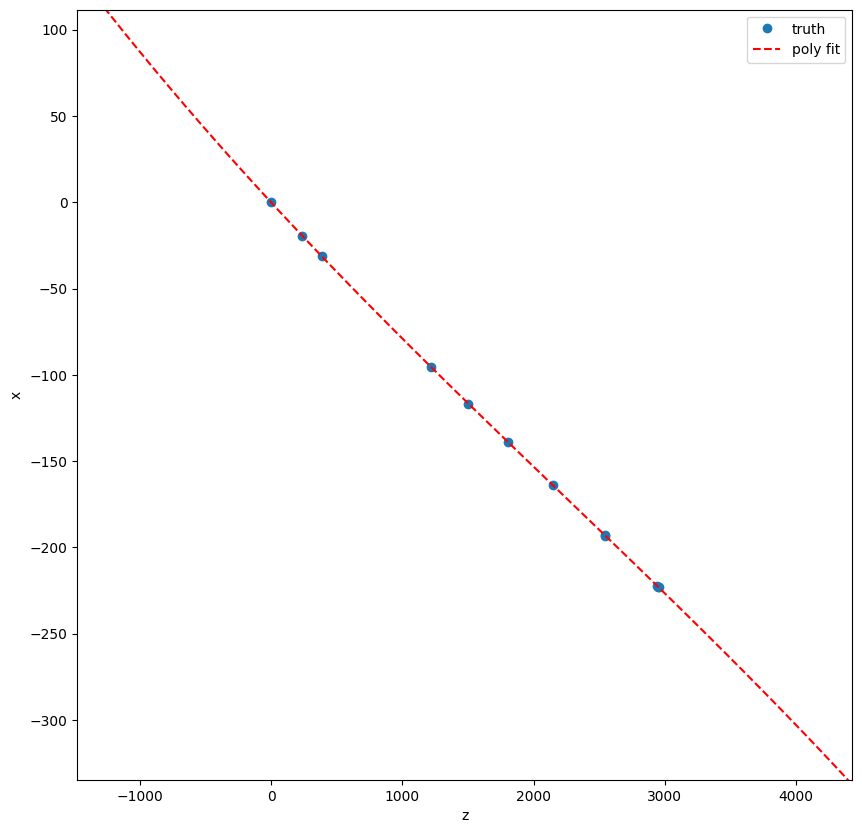

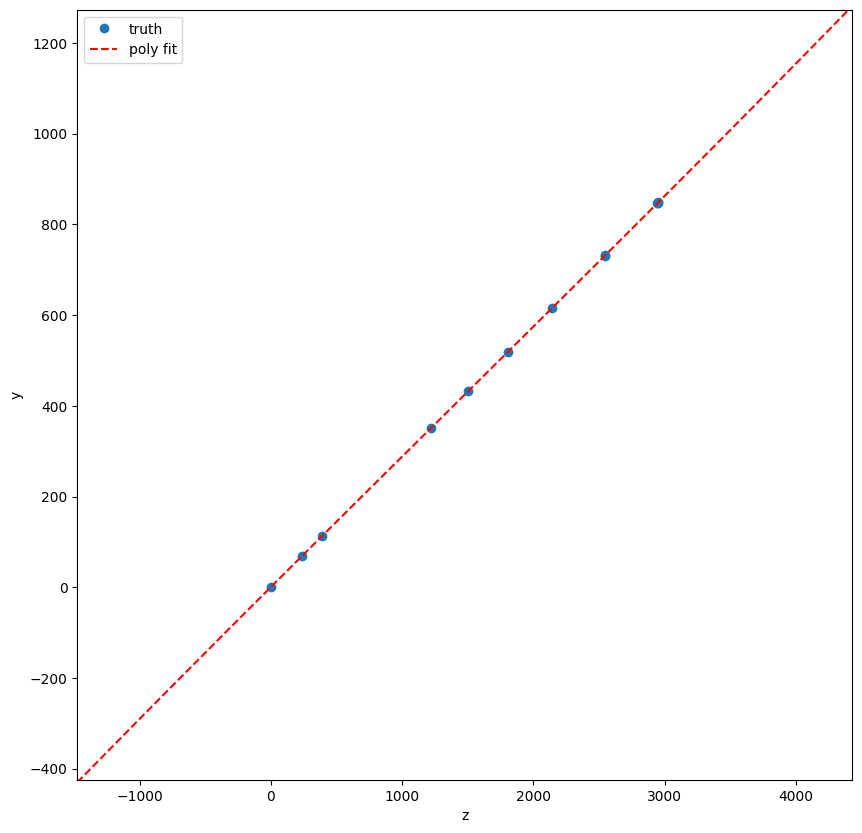

In [19]:
plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=3), 'x', label='truth')
plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=3), 'y', label='truth')

In [20]:
# preds = find_file(f"preds_{event_name}", dir=OUTPUT_DIR, extension="pkl")
outrunner_model_h = get_model(preload=True, save=False, dir=SOLUTION_DIR, inname="my_model_h.h5" )
module_id = get_module_id(event.hits)
used_model = outrunner_model_h

2023-08-29 00:04:06 DEBUG    Creating converter from 3 to 5


2023-08-29 00:04:07.208994: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:226] Using CUDA malloc Async allocator for GPU: 0
2023-08-29 00:04:07.209096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30935 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:02:00.0, compute capability: 7.0


In [21]:
from keras.models import Model
import numpy.typing as npt

## Get prediction

In [22]:
def get_path(
    hit_id: int,
    thr: float,
    mask: npt.NDArray,
    module_id: npt.NDArray,
    skip_same_module: bool = True,
    preds: list[npt.NDArray] | None = None,
    features: npt.NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
):
    """Predict set of hits that belong to the same track as hit_id.
    Returns list[hit_id].
    """
    # Verify correct input
    if preds is None:
        assert features is not None and hits is not None, "Either preds or features and truth must be provided"

    # Convert to index
    hit_index = hit_id - 1
    path_indices = [hit_index]
    a = 0
    while True:
        # Predict probability of each pair of hits with the last hit in the path
        hit_id_last = path_indices[-1] + 1
        if preds is not None:
            p = retrieve_predict(hit_id_last, preds)
        else:
            if features is None or hits is None or model is None:
                raise ValueError("Either preds or (features & hits & model) must be provided")

            p = make_predict(model=model, features=features, hits=hits, hit_id=hit_id_last, thr=thr)

    
        # TODO
        # p_ = p + diffs(p) * weight

        # Generate mask of hits that have a probability above the threshold
        mask = (p > thr) * mask
        # Mask last added hit
        mask[path_indices[-1]] = 0

        if skip_same_module:
            path_ids = np.array(path_indices) + 1
            mask = mask_same_module(mask, path_ids, p, thr, module_id)
            
        # TODO
        # if validator(x,y)

        # `a` is the culuminative probability between each hit in the path
        # At each step we look at the best candidate for the whole (previously geberate) track
        a = (p + a) * mask

        # Breaking condition: if best average probability is below threshold, end path
        if a.max() < thr * len(path_indices):
            break
        # Add index of hit with highest probability to path, proceed with this hit as the seed for the next iteration
        path_indices.append(a.argmax())  # type: ignore
    # Convert indices back to hit_ids by adding 1
    return np.array(path_indices) + 1

In [23]:
particle_data

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
25607,25608,4503805785800704,-19.553600,69.797699,238.080994,-2.96807,10.6732,37.389198,0.000095
31040,31041,4503805785800704,-31.384800,112.500999,387.628998,-2.94660,10.6807,37.388100,0.000080
75302,75303,4503805785800704,-95.355103,350.312988,1218.500000,-2.81631,10.7155,37.385502,0.000065
76418,76419,4503805785800704,-116.751999,432.333008,1504.500000,-2.77697,10.7279,37.383099,0.000053
77462,77463,4503805785800704,-138.906998,518.474976,1804.500000,-2.74663,10.7404,37.380600,0.000044
78450,78451,4503805785800704,-163.858002,616.510986,2145.500000,-2.72706,10.7517,37.378700,0.000029
93238,93239,4503805785800704,-193.011993,731.302979,2544.500000,-2.73814,10.7565,37.374500,0.000029
93242,93243,4503805785800704,-193.231995,732.166992,2547.500000,-2.73942,10.7560,37.374401,0.000029
93609,93610,4503805785800704,-222.487000,846.458008,2944.500000,-2.76844,10.7593,37.369801,0.000036
93618,93619,4503805785800704,-222.709000,847.322021,2947.500000,-2.76839,10.7585,37.369900,0.000050


In [24]:
particle_hit_idx = np.where(event.hits.hit_id.isin(particle_data.hit_id))[0]
particle_hit_idx 

array([25607, 31040, 75302, 76418, 77462, 78450, 93238, 93242, 93609,
       93610, 93618])

Test whether we got the right idx

In [25]:
event.truth.iloc[particle_hit_idx]

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
25607,25608,4503805785800704,-19.553600,69.797699,238.080994,-2.96807,10.6732,37.389198,0.000095
31040,31041,4503805785800704,-31.384800,112.500999,387.628998,-2.94660,10.6807,37.388100,0.000080
75302,75303,4503805785800704,-95.355103,350.312988,1218.500000,-2.81631,10.7155,37.385502,0.000065
76418,76419,4503805785800704,-116.751999,432.333008,1504.500000,-2.77697,10.7279,37.383099,0.000053
77462,77463,4503805785800704,-138.906998,518.474976,1804.500000,-2.74663,10.7404,37.380600,0.000044
78450,78451,4503805785800704,-163.858002,616.510986,2145.500000,-2.72706,10.7517,37.378700,0.000029
93238,93239,4503805785800704,-193.011993,731.302979,2544.500000,-2.73814,10.7565,37.374500,0.000029
93242,93243,4503805785800704,-193.231995,732.166992,2547.500000,-2.73942,10.7560,37.374401,0.000029
93609,93610,4503805785800704,-222.487000,846.458008,2944.500000,-2.76844,10.7593,37.369801,0.000036
93610,93611,4503805785800704,-223.078995,848.760986,2952.500000,-2.76502,10.7583,37.368801,0.000057


In [26]:
PATH_THR = 0.85
# hit_id_test = event.hits.hit_id.values[0]
# hit_id_test
hit_index_test = 0
hit_id_test = hit_index_test + 1
hit_id_test_real = event.hits.hit_id.values[hit_index_test]
hit_id_test_real, hit_id_test, hit_index_test

(1, 1, 0)

### Faux hit_id!

In [27]:
# intersection_idx = round(len(particle_hit_idx) / 2)
intersection_idx = 4
# intersection_idx = min(9, len(particle_hit_idx) - 1)
hit_id_test = particle_hit_idx[intersection_idx] + 1
hit_id_test

77463

In [28]:
path_test_idx = get_path(hit_id_test, thr=PATH_THR, mask = np.ones(len(event.hits)), module_id=module_id,features= event.features, hits=event.hits, model=used_model) -1
path_test_idx

1/1 [==============================] - 0s 17ms/step


array([77462, 78450, 76418, 93242, 93238, 75302, 93618, 93609, 93610,
       25615, 31047])

In [29]:
path_test_idx

array([77462, 78450, 76418, 93242, 93238, 75302, 93618, 93609, 93610,
       25615, 31047])

In [30]:
path_test_data = event.hits.iloc[path_test_idx]
path_test_data

,hit_id,x,y,z,volume_id,layer_id,module_id
77462,77463,-138.863998,518.419006,1804.500000,14,6,136
78450,78451,-163.903000,616.796021,2145.500000,14,8,135
76418,76419,-116.740997,432.381012,1504.500000,14,4,136
93242,93243,-193.151001,731.958984,2547.500000,18,10,79
93238,93239,-193.056000,731.593994,2544.500000,18,10,77
75302,75303,-95.390099,350.447998,1218.500000,14,2,134
93618,93619,-221.287994,843.218994,2947.500000,18,12,79
93609,93610,-221.729996,842.531982,2944.500000,18,12,77
93610,93611,-223.570999,850.726990,2952.500000,18,12,78
25615,25616,-33.507401,64.121300,242.352997,8,4,347


### Append origin and select 3 hits

In [31]:
cut_off_idx = min(2, len(path_test_data))
X_t_3, Y_t_3, Z_t_3 = path_test_data[['x', 'y', 'z']].values[:cut_off_idx].T
X_t, Y_t, Z_t = path_test_data[['x', 'y', 'z']].values.T

X_t = np.append(X_t, x_0)
Y_t = np.append(Y_t, y_0)
Z_t = np.append(Z_t, z_0)
X_t_3 = np.append(X_t_3, x_0)
Y_t_3 = np.append(Y_t_3, y_0)
Z_t_3 = np.append(Z_t_3, z_0)
X_t_3, Y_t_3, Z_t_3

(array([-138.86399841, -163.90299988,    0.        ]),
 array([518.41900635, 616.79602051,   0.        ]),
 array([1804.5, 2145.5,    0. ]))

## Poly fit reco

### Plot truth vs reco

<Axes: xlabel='z', ylabel='y'>

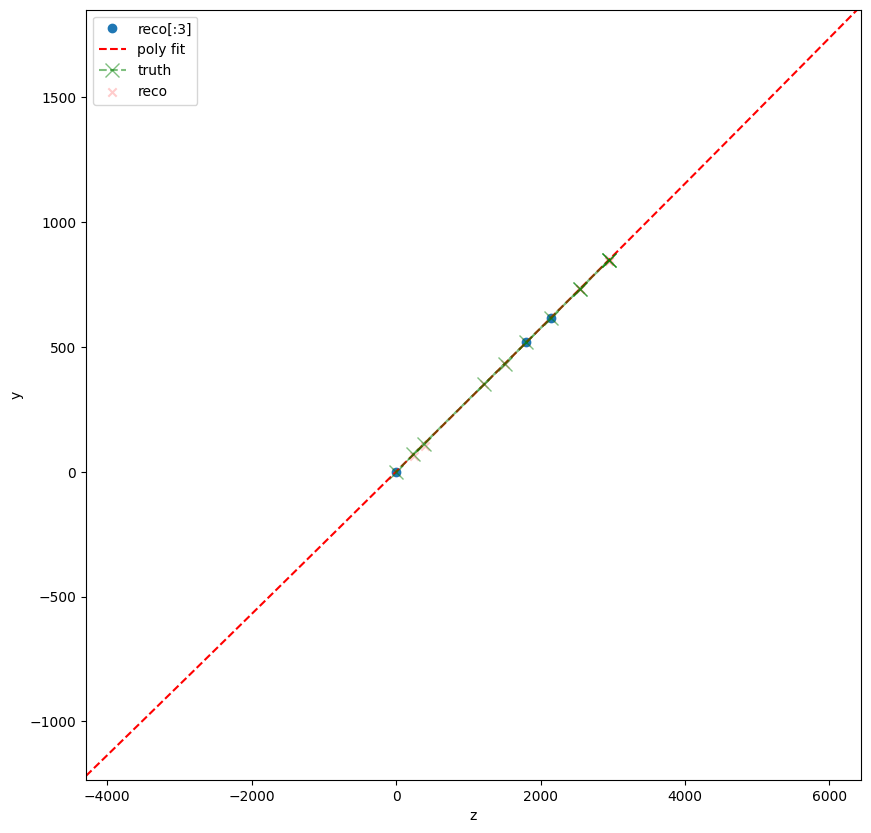

In [32]:
fig, ax = plot_fit(X_t_3,Y_t_3,Z_t_3, *do_fit(X_t_3,Y_t_3,Z_t_3, deg=2, crop=5), 'y', label='reco[:3]', crop=5)
ax.plot(Z,Y,'g--', label='truth', marker='x', markersize=10, alpha=0.5)
ax.scatter(Z_t, Y_t, color='red', marker='x',label='reco', alpha= 0.2)
ax.legend()
ax

(-578.358039855957, 355.2790451049805) (-42.43804931640631, 891.1990356445312)


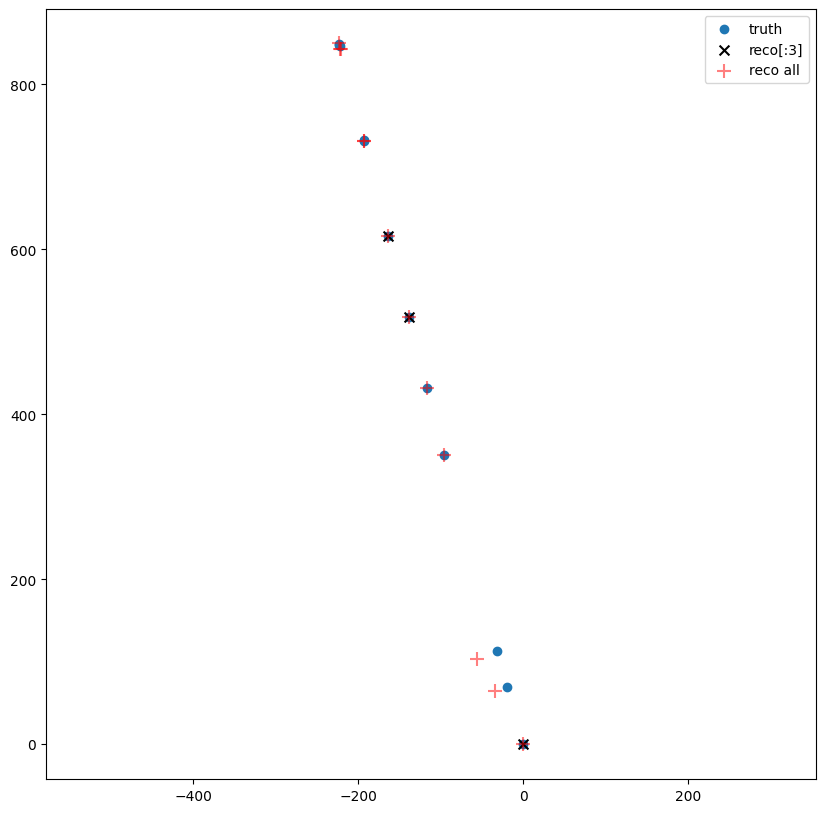

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X,Y, label='truth')
ax.scatter(X_t_3,Y_t_3, marker='x', label='reco[:3]',color='black', s=50)
ax.scatter(X_t, Y_t, color='red', marker='+',label='reco all', alpha=0.5, s=100)
ax.set_aspect('equal', 'box')

xlim, ylim = get_crop(X,Y, crop = 1.1, square = True)
print(xlim, ylim)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend()

# Circle fit $x, y$ plane

Select three hits

In [34]:
X_3 = X[[0, round(len(X)/2) - 1, -1 ]]
Y_3 = Y[[0, round(len(Y)/2) - 1, -1 ]]

### Define functions

In [35]:
from typing import Iterable
from scipy.optimize import curve_fit, minimize

def _input_to_points_xy(*args: tuple[tuple[float,float],tuple[float,float],tuple[float,float]] | tuple[tuple[float, float, float], tuple[float,float,float]] | tuple[Iterable, Iterable] | tuple[Iterable,Iterable,Iterable]) -> tuple[tuple[float, float], tuple[float, float], tuple[float, float]]:
    # Input [(x1, y1), (x2, y2), (x3, y3)]
    if len(args) == 3:
        p1, p2, p3 = args
    # Input [x1, x2, x3], [y1, y2, y3]
    elif len(args) == 2:
        X_arr, Y_arr = args
        assert len(X_arr) == len(Y_arr) == 3, "Input must be a tuple of three points or a tuple of two arrays of points."
        p1, p2, p3 = (X_arr[0], Y_arr[0]), (X_arr[1], Y_arr[1]), (X_arr[2], Y_arr[2]) # type: ignore
    else:
        raise ValueError("Input must be a tuple of three points or a tuple of two arrays of points.")
    return p1, p2, p3 # type: ignore


def define_circle(p1, p2, p3) -> tuple[tuple[float, float], float]:
    """Define a circle from three points. Returns (center_x, center_y), radius."""
    x = complex(p1[0], p1[1]) # type: ignore
    y = complex(p2[0], p2[1]) # type: ignore
    z = complex(p3[0], p3[1]) # type: ignore
    
    w = (z-x)
    w/=(y-x)
    c = (x - y) * (w - abs(w) ** 2) / 2j / w.imag - x
    r = abs(c + x)
    c1, c2 = (-c.real, -c.imag)
    return ((c1, c2), r)


def validator_circle(x: float, y: float, center: tuple[float, float], r: float, abs_tolerance = 0, rel_tolerance = 0, info: bool = False, **kwargs) -> bool | dict:
    """Validate a point against a circle."""
    dx = x - center[0]
    dy = y - center[1]
    dist = np.sqrt(dx ** 2 + dy ** 2) # distance from center of given circle
    diff = abs(dist - r) # difference between distance and radius
    validated = diff <= abs_tolerance or diff <= rel_tolerance * r ** 2
    if kwargs.get('verbose') == True:
        print("on circle:", validated, "diff", diff, r, dist )
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "diff": diff,
        }


def validator_line_xy(x: float, y: float, slope: float, intercept: float, abs_tolerance: float = 0, rel_tolerance: float = 0, info: bool = False) -> bool | dict:
    """Validate a point against a line."""
    diff = abs(y - (slope * x + intercept))
    validated = diff <= abs_tolerance or diff <= rel_tolerance * abs(y)
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "diff": diff,
        }


def get_validator_xy(*args: tuple[tuple[float,float],tuple[float,float],tuple[float,float]] | tuple[tuple[float, float, float], tuple[float,float,float]] | tuple[Iterable, Iterable] | tuple[Iterable,Iterable,Iterable], thr_collinear =  1.0e-6, **kwargs):
    """Get validation function for a track in x, y plane."""
    p1, p2, p3 = _input_to_points_xy(*args)


    # Check if points are collinear
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1]) # type: ignore
    if abs(det) < thr_collinear:
        # Since collinear, only need to check two points
        # TODO: expand to 3D
        slope, intercept = np.polyfit([p1[0], p2[0]], [p1[1], p2[1]], 1)
        print("Validator is line")
        return lambda x, y: validator_line_xy(x, y, slope, intercept, **kwargs)
    # Circle
    else:
        center, r = define_circle(p1, p2, p3)
        print("Validator is circle")
        return lambda x, y: validator_circle(x, y, center, r, **kwargs)

### 

In [36]:
# x, y =  [2,100,0],[0,1,0]
# center, r = define_cirlce(x, y)
# center, r = define_circle(*_input_to_points_xy(X_3, Y_3))
center, r = define_circle(*_input_to_points_xy(X_t_3, Y_t_3))
# _input_to_points_xy(X_3, Y_3)
# X_3, Y_3
center, r

((24613.020364179407, 6870.6646848956625), 25553.997821471745)

### Plot fits

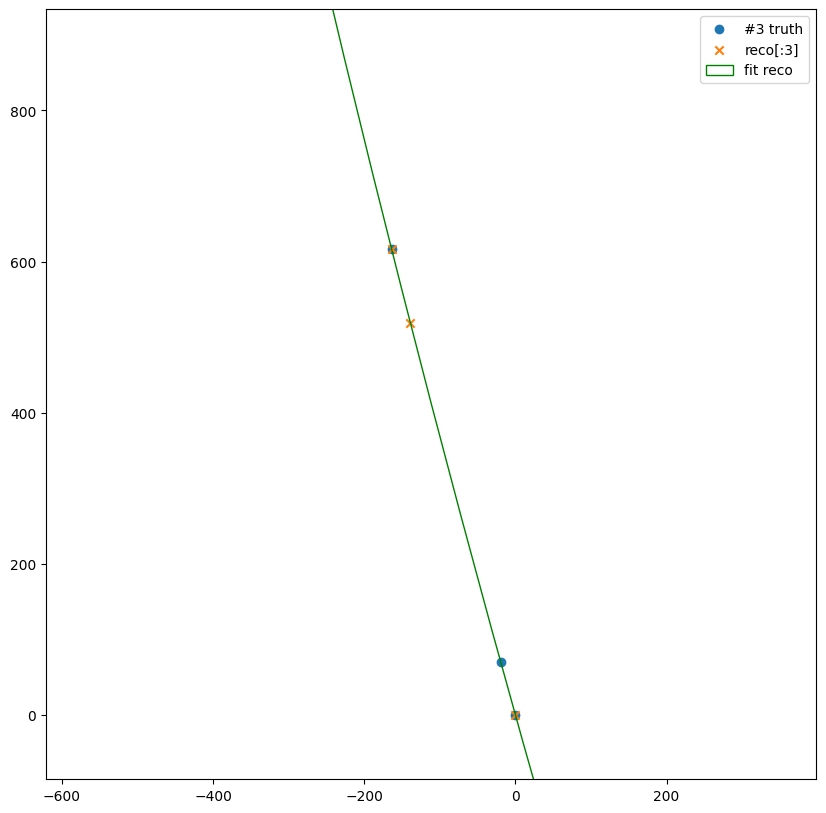

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

crop = 1.2
xlim, ylim = get_crop(X, Y, crop=crop, square=True)

ax.scatter(X_3,Y_3, label='#3 truth')
ax.scatter(X_t_3,Y_t_3, marker='x', label='reco[:3]')

circle = plt.Circle(center, r, fill=False, color='g', label = 'fit reco')
ax.add_patch(circle)

ax.set_aspect('equal', 'box')
ax.set(xlim=xlim, ylim=ylim)
ax.legend()

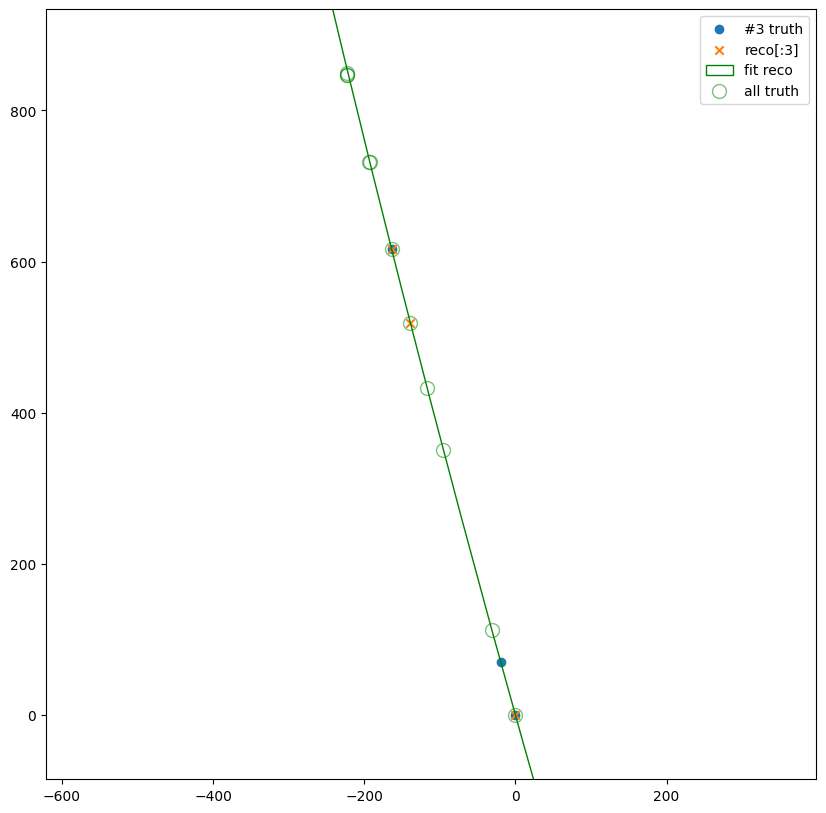

In [38]:
ax.plot(X[1:],Y[1:],'o', color='green', fillstyle='none', alpha=0.5, label = 'all truth', markersize=10)
ax.legend()
fig

In [39]:
# ax.scatter(X_t, Y_t)
# fig

Test circle fit with truth data

In [40]:
validator_xy = get_validator_xy(X_t_3,Y_t_3, abs_tolerance=5)
# print(X, Y, Z)

for x, y in zip(X,Y):
    validator_xy(x, y)

Validator is circle


In [41]:
allowed = np.array([validator_xy(x, y) for x, y in zip(X_t,Y_t)])

In [42]:
allowed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True])

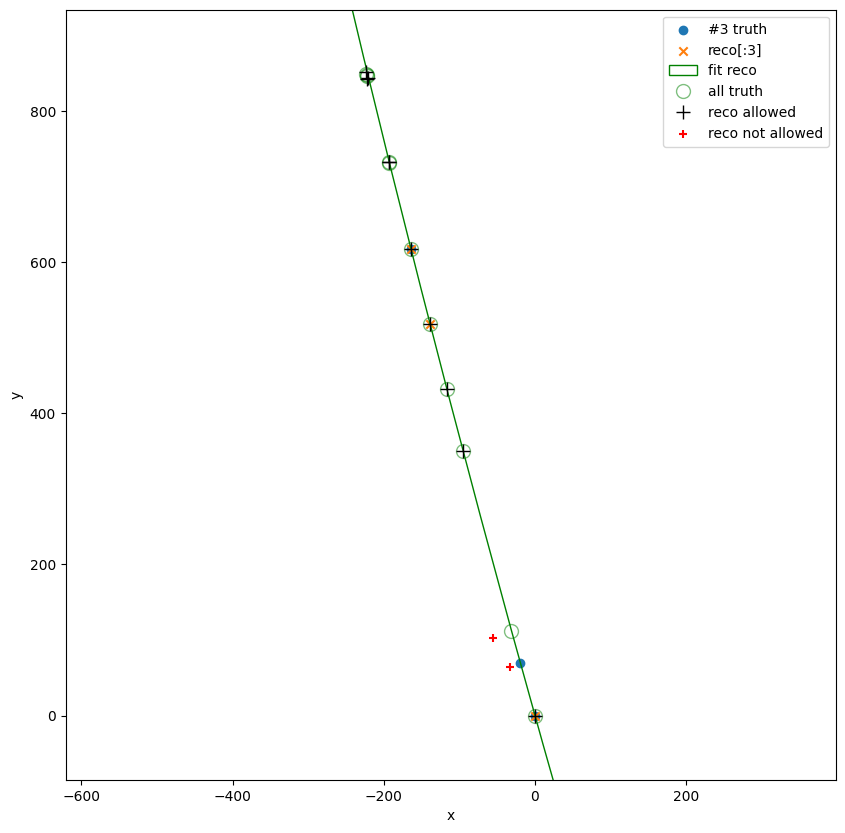

In [43]:
ax.plot(X_t[allowed], Y_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.scatter(X_t[~allowed], Y_t[~allowed], color='red', marker='+', label='reco not allowed')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
fig

# Sine fit $x, z$ and $y, z$ planes

If circle is defined by: $ (x-c_x)^2 + (y-c_y)^2 = R^2$

let: 

$
\begin{equation}
y(z) = c_y + R \cdot \sin[f(z - z_0) + \phi_0]
\end{equation} \\
\begin{equation}
x(z) = c_x + R \cdot \cos[f(z - z_0) + \phi_0]
\end{equation}
$

We assume 

$
\begin{equation}
y(z_0) = 0  \\
\therefore \phi_0 =  \arcsin{-\frac{c_y}{R}}
\end{equation}
$

Similarly 
$
\begin{equation}
x(z_0) = 0 \therefore \phi_0 =  \arcsin{-\frac{c_y}{R}} = \arccos{-\frac{c_x}{R}}
\end{equation}
$

We are only missing $f$ in equations (1)

In [44]:
def trig(x, A, B, f, phi_0, z_0, intercept):
    if A == 0:
        return B * np.cos(f * (x + z_0) + phi_0) + intercept 
    if B == 0:
        return A * np.sin(f * (x + z_0) + phi_0) + intercept

    _sin = np.sin(f * (x + z_0) + phi_0)
    _cos = np.cos(f * (x + z_0) + phi_0)
    return A * _sin + B * _cos + intercept

## Plot xz, yz planes

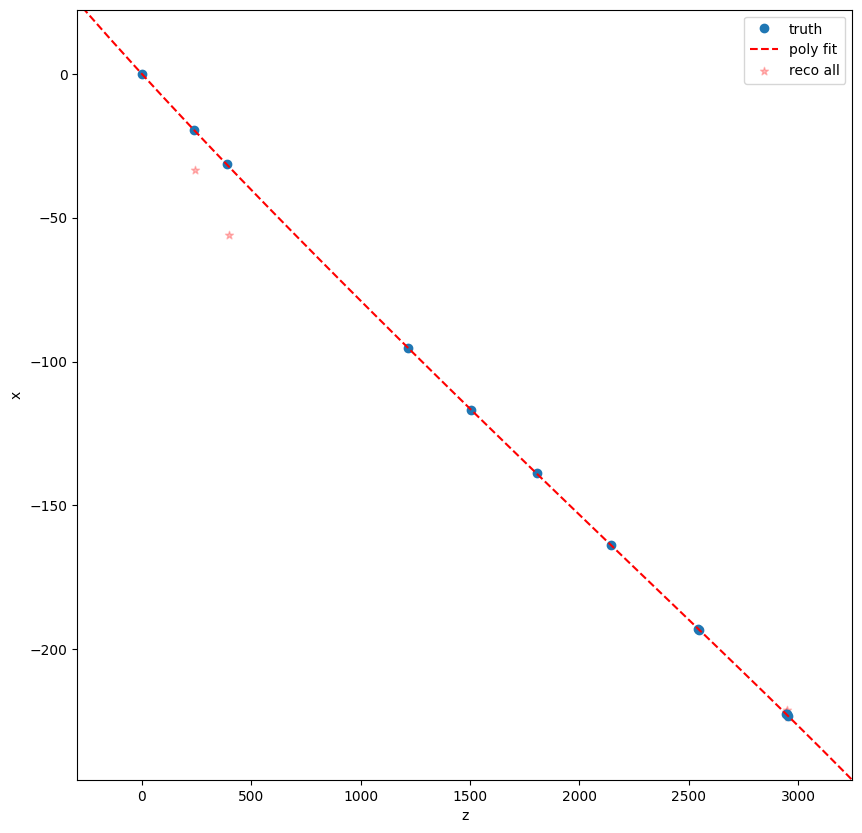

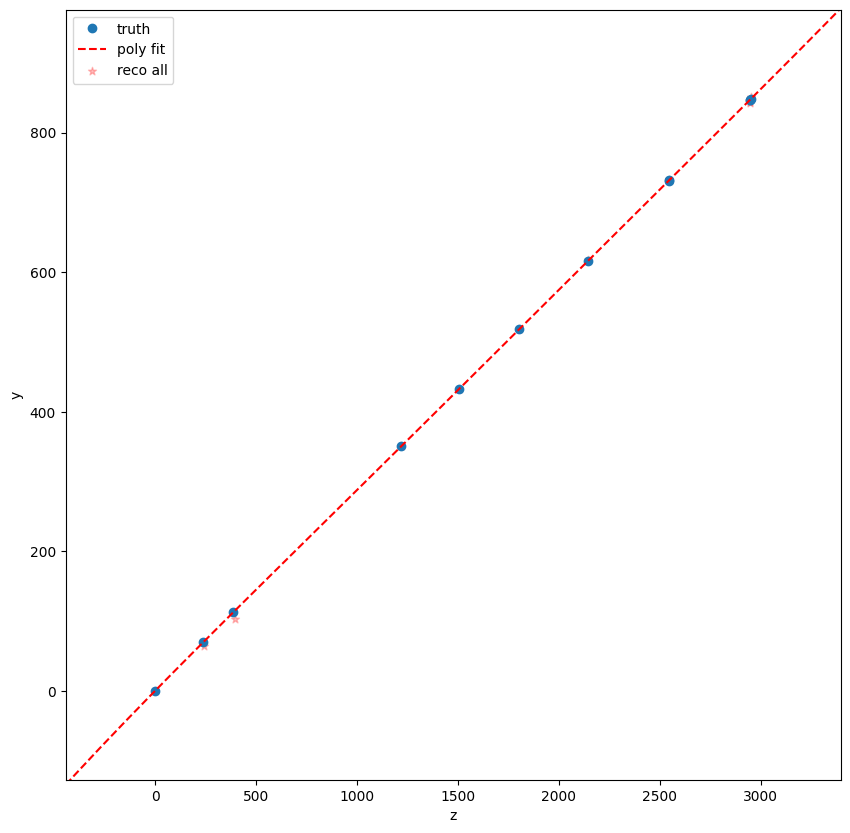

In [45]:
fig_zx, ax_zx = plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=5), 'x',crop=1.2, label ='truth')
fig_zy, ax_zy = plot_fit(X,Y,Z, *do_fit(X,Y,Z,  deg=5), 'y',crop=1.3, label='truth')
ax_zx.scatter(Z_t, X_t, color='red', marker='*',label='reco all', alpha=0.25)
ax_zy.scatter(Z_t, Y_t, color='red', marker='*',label='reco all', alpha=0.25)
ax_zx.legend()
ax_zy.legend()

6870.6646848956625


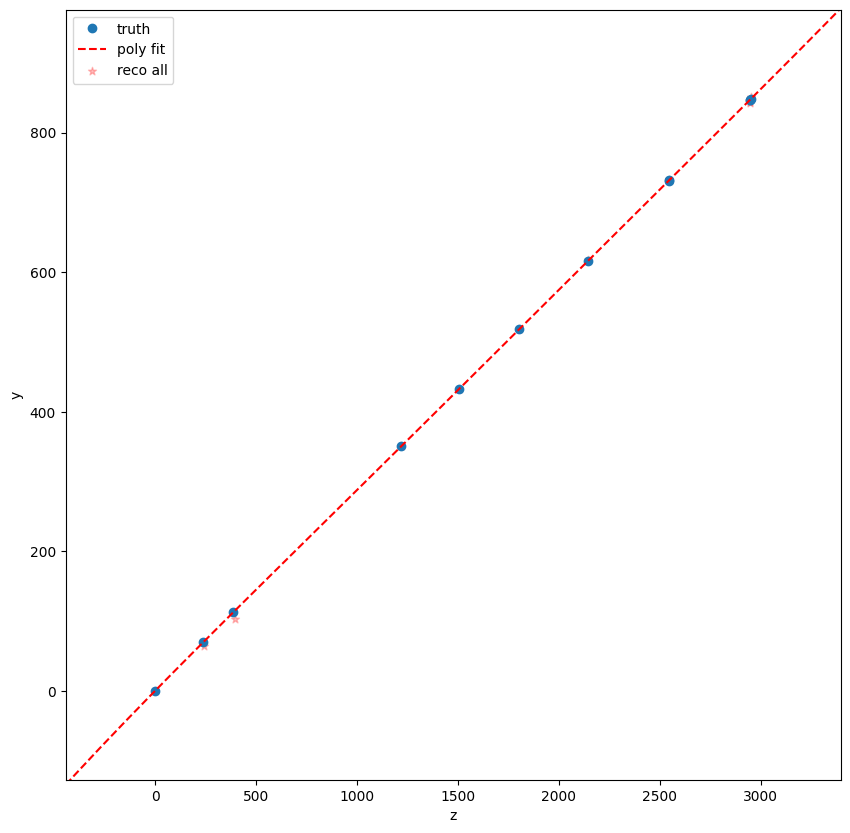

In [46]:
# Use that it passes through origin, so R * sin(f * x + phi) = -y0 |x=0
center_x, center_y = center
print(center_y)
ax_zy.plot([-3000, 1000], [center_y, center_y], color="black", linestyle="dashed")
fig_zy

## Calculate $\phi_0$

In [47]:
center

(24613.020364179407, 6870.6646848956625)

In [48]:
# _center_x, _center_y = center
import math
_r = 1
_theta = np.pi/4
_center_x, _center_y = _r * np.cos(_theta), _r * np.sin(_theta)
print('truth',( _theta + 2 * np.pi % (2 * math.pi)) - np.pi)

truth -2.356194490192345


In [49]:
(_center_x, _center_y), _r = center, r
print('atan', (math.atan2(_center_y, _center_x) + np.pi) %(2*np.pi))
print('atan2', math.atan2(-_center_y, -_center_x))
phi_0_x = np.arccos(-_center_x/_r )
phi_0_y = np.arcsin(-_center_y/_r )
if center_x > 0:
    phi_0_y += np.pi
if center_y < 0:
    phi_0_x *= -1
phi_0 = (phi_0_y + phi_0_x)/2
print("phi_0_x: ", phi_0_x)
print("phi_0_y: ", phi_0_y)
print("diff: ", phi_0_x - phi_0_y )
print("diff - pi: ", abs(phi_0_x - phi_0_y) - np.pi )
print("%: ", 100* (phi_0_x - phi_0_y)/phi_0)
print("phi_0: ", phi_0, "radians", phi_0/np.pi, "pi's")

atan 3.413810718484158
atan2 -2.869374588695428
phi_0_x:  2.8693745886954276
phi_0_y:  2.869374588695428
diff:  -4.440892098500626e-16
diff - pi:  -3.1415926535897927
%:  -1.5476864247688532e-14
phi_0:  2.869374588695428 radians 0.9133502987463029 pi's


In [50]:
def get_phi_0(center, r, single=True):
    # phi_0_y = np.arcsin(-center_y / r)
    # if single:
    #     return phi_0_y
    # phi_0_x = np.arccos(-center_x / r)
    # phi_0 = (phi_0_y + phi_0_x)/2
    # # TODO: test for diff phi_0
    return math.atan2(-_center_y, -_center_x)

In [51]:
phi_0 = get_phi_0(center, r)
phi_0

-2.869374588695428

## Estimate $f$

for each point in the reco list $p_i \in \set{p1, p2, p3, ...}$ that should be on the helix

where a point $p_i$ defines the coordinate
$\begin{bmatrix} 
x \\
y \\
z
\end{bmatrix}$

assuming the helix also passes through 
$p_0 = 
\begin{bmatrix} 
0 \\
0 \\
z_0
\end{bmatrix}$

we can use $p_x = x(p_z) = c_x + R \cdot \cos[f(p_z - z_0) + \phi_0]$
to get

$
\begin{equation}
f = \frac{\arccos{\frac{p_x-c_x}{R}-\phi_0}}{p_z - z_0}
\end{equation}
$

and similarly $p_y = y(p_z) = c_y + R \cdot \sin[f(p_z - z_0) + \phi_0]$

$ 
\begin{equation}
\therefore
f = \frac{\arcsin{\frac{p_y-c_y}{R}-\phi_0}}{p_z - z_0}
\end{equation}
$

In [52]:
p1 = (X_t_3[0], Y_t_3[0], Z_t_3[0])
a, b, c = p1
_f_y = (np.arcsin((b-center_y)/r) - phi_0) / (c - 0)
1/_f_y

689.2246785974537

In [53]:
p1 = (X_t_3[0], Y_t_3[0], Z_t_3[0])
a, b, c = p1
_f_x = (np.arccos((a-center_x)/r) - phi_0) / (c - 0)
1/_f_x, _f_x

(313.29474176600183, 0.0031918824885573556)

In [54]:
print("Diff", _f_x - _f_y)
print("Rel", 2 * (_f_x - _f_y)/ (_f_x + _f_y))

Diff 0.0017409768099694062
Rel 0.7499703830079651


In [55]:
phi_0 = math.atan2(-_center_y, -_center_x)
f_z = (math.atan2(b-center_y, a-center_x) - phi_0)/(c-0)
1/f_z

-85917.22540070063

In [56]:
def get_f(x: float, y: float, z: float, center: tuple[float, float], r: float, phi_0: float, z_0: float, single = True):
    """Get frequency f of helix passing through point (x, y, z) and (0, 0, z_0) with parameters `center`, `r`, `phi_0` and `z_0`."""

    assert z != z_0, "z and z_0 must be different"
    
    center_x, center_y = center
    # f_x = (np.arccos((x - center_x) / r) - phi_0) / (z - z_0)

    # if single:
    #     return f_x
    # f_y = (np.arcsin((y - center_y) / r) - phi_0) / (z - z_0)
    
    # f = (f_x + f_y) / 2

    # return f

    return (math.atan2(y - center_y, x - center_x) - phi_0) / (z - z_0)

In [57]:
f_cand = []
for p in zip(X_t_3, Y_t_3, Z_t_3):
    a, b, c = p
    if c == z_0:
        continue
    f_cand.append(get_f(a, b, c, center, r, phi_0, z_0))
_f = sum(f_cand)/len(f_cand)
diffs = [2 * abs(_f - f_) for f_ in f_cand]
print("Diff: ", sum(diffs))
print("Rel: ", sum(diffs)/_f)

Diff:  3.3328979834677645e-09
Rel:  -0.00028633284919068975


In [58]:
def get_f_all(x_arr: Iterable[float], y_arr: Iterable[float], z_arr: Iterable[float], center: tuple[float, float], r: float, phi_0: float, z_0: float, single = True):
    f_cand = []
    for x, y, z in zip(x_arr, y_arr, z_arr):
        if z == z_0:
            continue
        print(x, y, z)
        print(get_f(x, y, z, center, r, phi_0, z_0, single))
        f_cand.append(get_f(x, y, z, center, r, phi_0, z_0, single))
    f = sum(f_cand) / len(f_cand)
    return f

In [59]:
f = get_f_all(X_t_3, Y_t_3, Z_t_3, center, r, phi_0, z_0)
1/f

-138.86399841308594 518.4190063476562 1804.5
-1.1639109565470737e-05
-163.9029998779297 616.7960205078125 2145.5
-1.164077601446247e-05


-85911.07516971474

### Plot corresponding $\sin$, $\cos$ funcs

(0.0, 850.7269897460938)


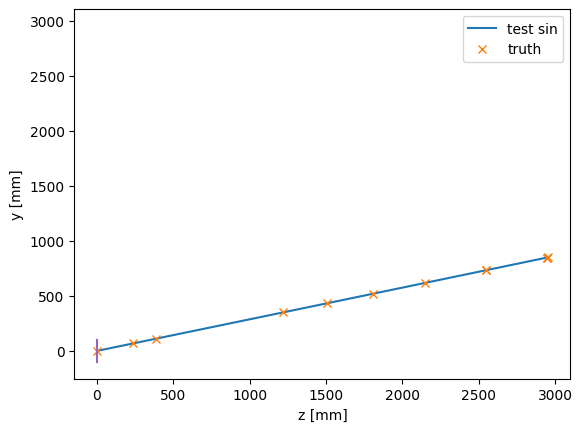

In [60]:
z_range = min(min(Z), min(Z_t)), max(max(Z), (max(Z_t)))
y_range = min(min(Y), min(Y_t)), max(max(Y), (max(Y_t)))
print(y_range)
z_in = np.linspace(*z_range, 1000)
plt.plot(z_in, r*np.sin(phi_0 + f*z_in) + center_y, label="test sin")
plt.plot(Z,Y,'x', label='truth')
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
plt.plot(*z_range,[0,0])
plt.plot([0,0],[-100,100])
plt.legend()
# plt.ylim(*y_range)
# r*np.sin(phi_0_2 + 0) + center_y

In [61]:
y_z = r*np.sin(phi_0 + z_in *f) + center_y
y_z

array([0.00000000e+00, 8.46724761e-01, 1.69345765e+00, 2.54019867e+00,
       3.38694782e+00, 4.23370509e+00, 5.08047050e+00, 5.92724402e+00,
       6.77402567e+00, 7.62081545e+00, 8.46761334e+00, 9.31441936e+00,
       1.01612335e+01, 1.10080558e+01, 1.18548861e+01, 1.27017246e+01,
       1.35485712e+01, 1.43954259e+01, 1.52422888e+01, 1.60891597e+01,
       1.69360388e+01, 1.77829260e+01, 1.86298212e+01, 1.94767246e+01,
       2.03236361e+01, 2.11705557e+01, 2.20174835e+01, 2.28644193e+01,
       2.37113632e+01, 2.45583152e+01, 2.54052753e+01, 2.62522436e+01,
       2.70992199e+01, 2.79462043e+01, 2.87931969e+01, 2.96401975e+01,
       3.04872062e+01, 3.13342230e+01, 3.21812479e+01, 3.30282809e+01,
       3.38753220e+01, 3.47223712e+01, 3.55694285e+01, 3.64164938e+01,
       3.72635673e+01, 3.81106488e+01, 3.89577384e+01, 3.98048361e+01,
       4.06519419e+01, 4.14990558e+01, 4.23461778e+01, 4.31933078e+01,
       4.40404459e+01, 4.48875921e+01, 4.57347464e+01, 4.65819087e+01,
      

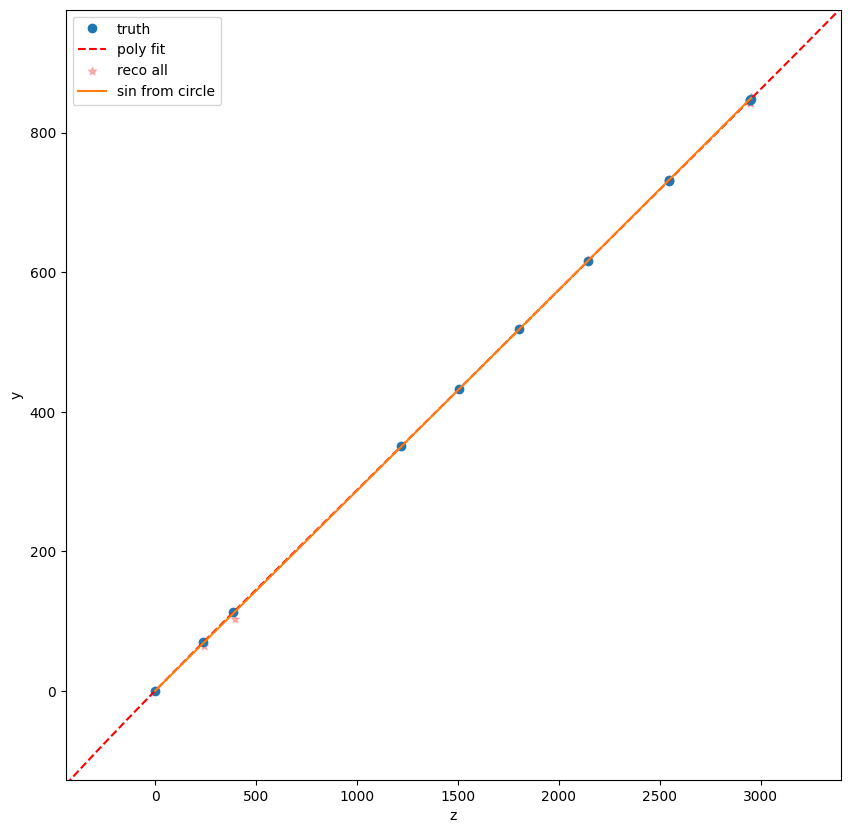

In [62]:
ax_zy.plot(z_in, y_z, label="sin from circle")
ax_zy.legend()
fig_zy

In [63]:
x_z = r*np.cos(phi_0 + z_in *f) + center_x
x_z

array([   0.        ,   -0.23634546,   -0.47266178,   -0.70894898,
         -0.94520705,   -1.18143599,   -1.4176358 ,   -1.65380648,
         -1.88994803,   -2.12606045,   -2.36214374,   -2.59819789,
         -2.83422292,   -3.07021881,   -3.30618557,   -3.5421232 ,
         -3.7780317 ,   -4.01391106,   -4.2497613 ,   -4.48558239,
         -4.72137436,   -4.95713719,   -5.19287089,   -5.42857545,
         -5.66425087,   -5.89989717,   -6.13551432,   -6.37110234,
         -6.60666123,   -6.84219098,   -7.07769159,   -7.31316307,
         -7.54860541,   -7.78401861,   -8.01940267,   -8.2547576 ,
         -8.49008339,   -8.72538004,   -8.96064755,   -9.19588592,
         -9.43109515,   -9.66627525,   -9.9014262 ,  -10.13654802,
        -10.37164069,  -10.60670422,  -10.84173862,  -11.07674387,
        -11.31171998,  -11.54666694,  -11.78158477,  -12.01647345,
        -12.25133299,  -12.48616339,  -12.72096465,  -12.95573676,
        -13.19047973,  -13.42519355,  -13.65987823,  -13.89453

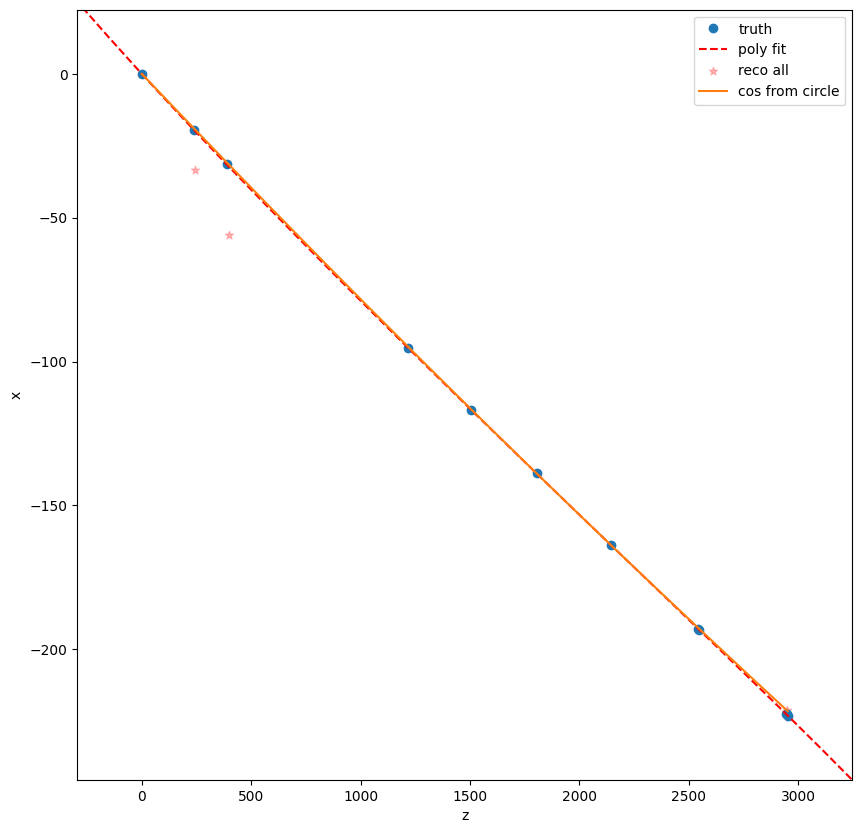

In [64]:
ax_zx.plot(z_in, x_z, label="cos from circle")
ax_zx.legend()
fig_zx

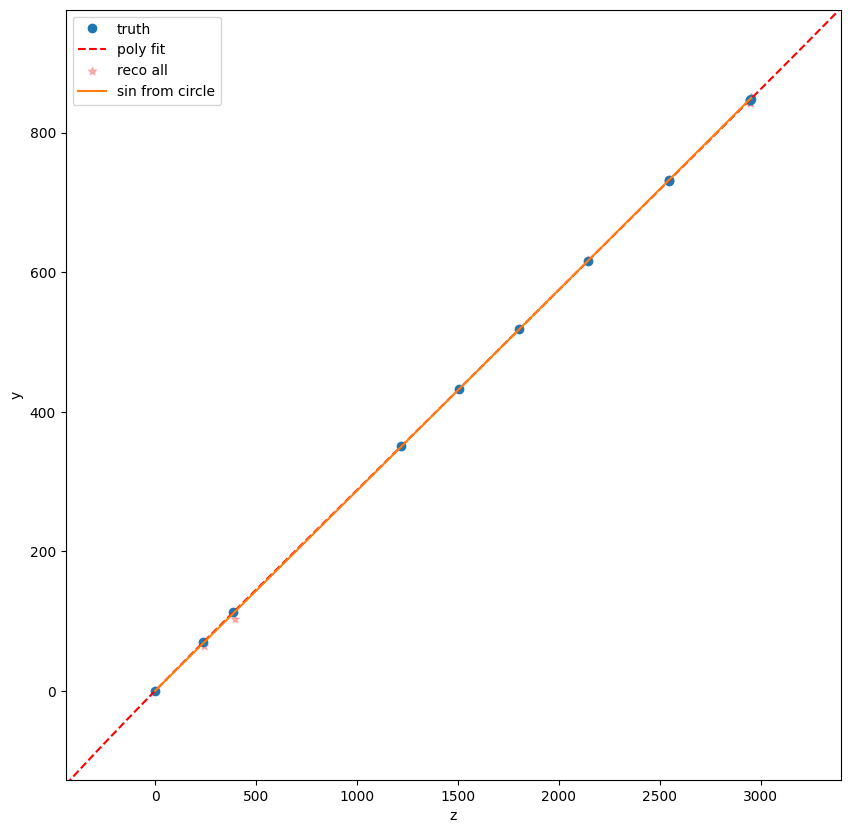

In [65]:
fig_zy

## Curve fit $f$

In [66]:
z_0, 1/f, r, phi_0

(0, -85911.07516971474, 25553.997821471745, -2.869374588695428)

In [67]:
sin_test = lambda x, f: trig(x, r, 0, f, phi_0, z_0, center_y)
curve_fit(sin_test, Z_t_3, Y_t_3, p0=(1/4000) )

(array([-1.16400864e-05]), array([[3.36818813e-19]]))

In [68]:
from scipy.optimize import curve_fit

z_0=0
# phi_0 = np.arcsin(-center_y/r ) 
# sin_test = lambda x, f, phi_0: trig(x, r, 0, f, phi_0, z_0, center_y)
# cos_test = lambda x, f, phi_0: trig(x, 0, r, f, phi_0, z_0, center_x)
sin_test = lambda x, f: trig(x, r, 0, f, phi_0, z_0, center_y)
cos_test = lambda x, f: trig(x, 0, r, f, phi_0, z_0, center_x)

# popt_zy, pcov = curve_fit(sin_test, Z[4:], Y[4:], p0=(1/4000,np.arcsin(- center_y / r)) )
# popt_zy, pcov = curve_fit(sin_test, Z[4:], Y[4:], p0=(1/4000) )
popt_zy, pcov = curve_fit(sin_test, Z_t_3, Y_t_3, p0=(1/4000) )
popt_zx, pcov = curve_fit(cos_test, Z_t_3, X_t_3, p0=(1/4000) )

# popt_zy, pcov = curve_fit(sin_test, Z, Y, p0=((1/4000),0))
# f, phi_0, z_0 = popt
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]
fitted_func_zx = lambda x_arr: [cos_test(x, *popt_zx) for x in x_arr]
1/popt_zx[0], 1/popt_zy[0]

(-85910.11457990979, -85910.01519331735)

In [69]:
f_zy  = popt_zy
f_zx  = popt_zx
f = np.mean([f_zy, f_zx])
1/f

-85910.06488658482

### Plot $z, y$

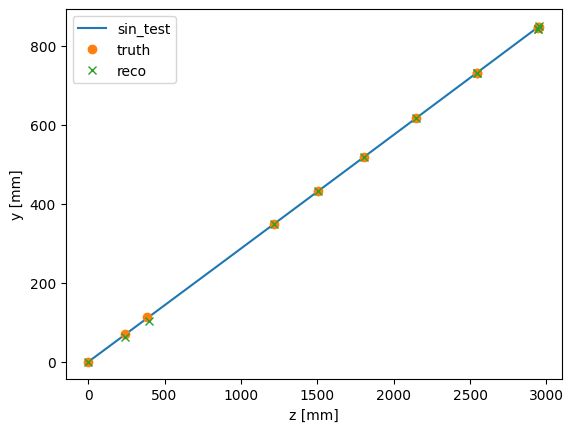

In [70]:
# Z, Y
# plt.plot(z_in, [ sin_test(x, f) for x in z_in], label='sin_test')
plt.plot(z_in, [ sin_test(x, f_zx) for x in z_in], label='sin_test')
plt.plot(Z, Y, 'o', label='truth')
plt.plot(Z_t, Y_t, 'x', label='reco')
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
plt.legend()

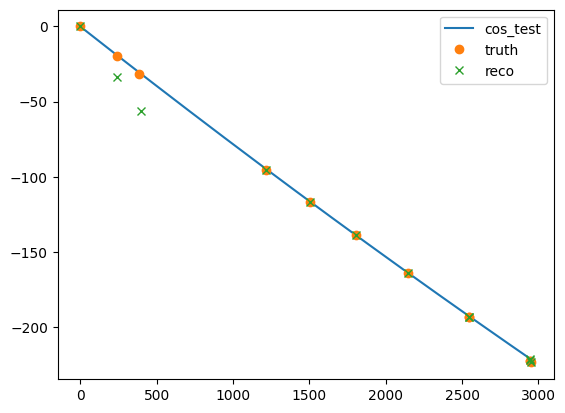

In [71]:
# Z, X
plt.plot(z_in, [ cos_test(x, f) for x in z_in], label='cos_test') 
plt.plot(Z, X, 'o', label='truth')
plt.plot(Z_t, X_t, 'x', label='reco')
plt.legend()

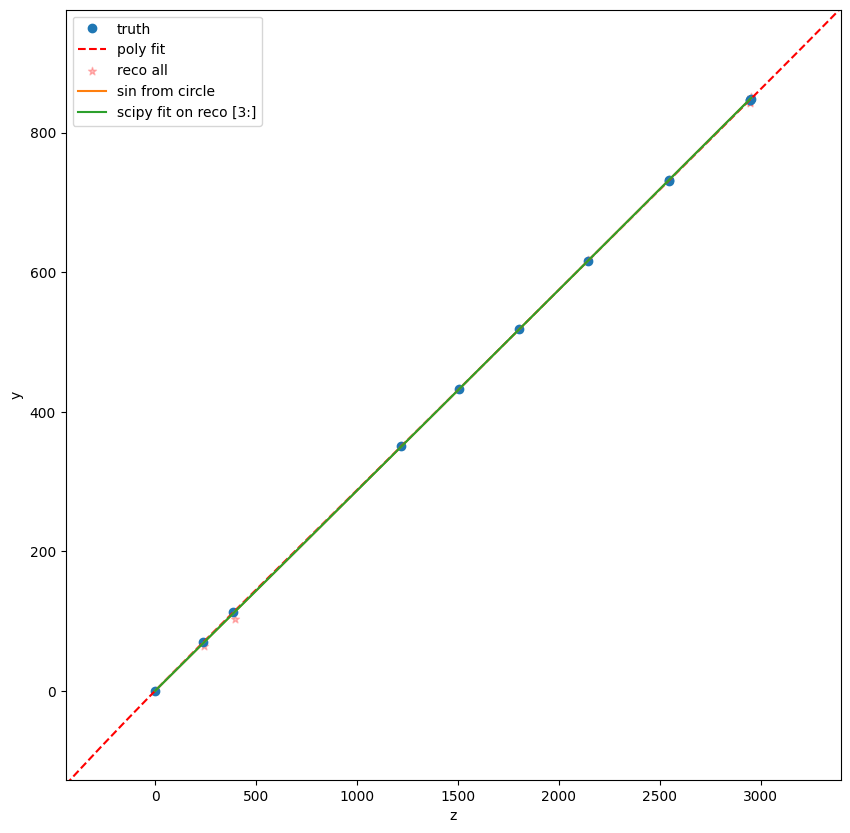

In [72]:
# ax_zy.plot(z_in, fitted_func(z_in), label='scipy fit on truth [:4]')
ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on reco [3:]')
ax_zy.legend()
fig_zy

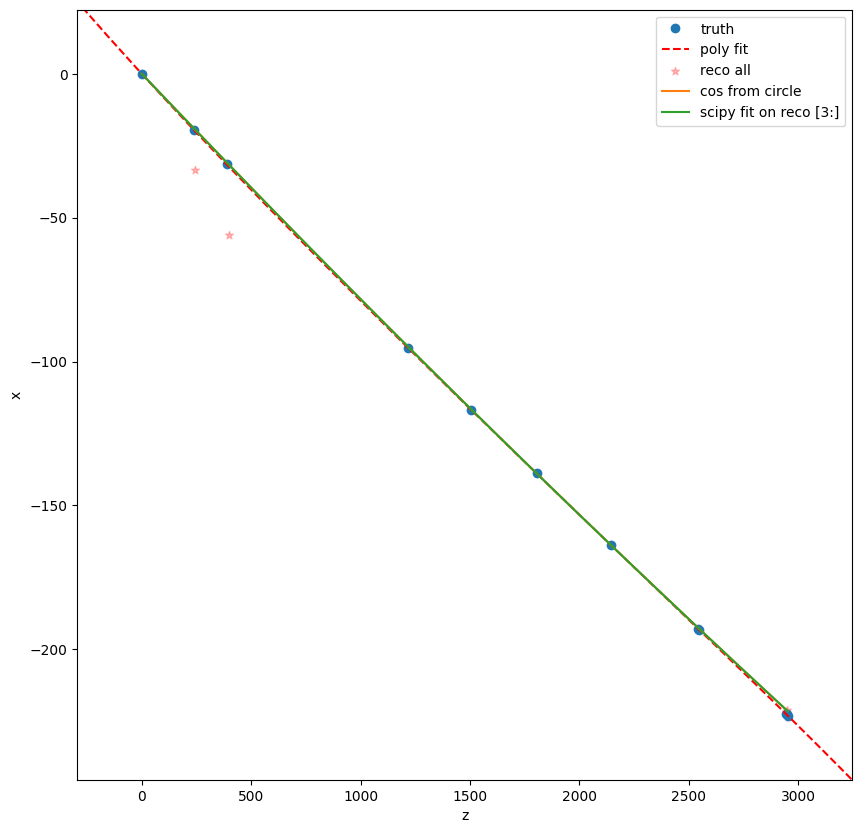

In [73]:
ax_zx.plot(z_in, fitted_func_zx(z_in), label='scipy fit on reco [3:]')
ax_zx.legend()
fig_zx

fit on right 4 hits of truth

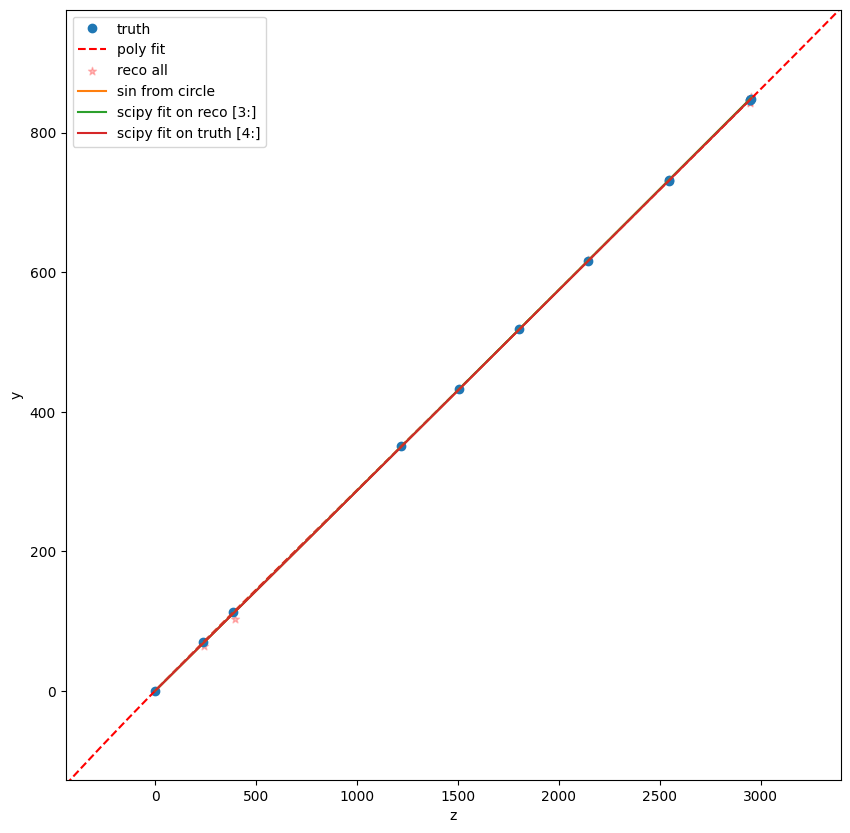

In [74]:
popt_zy, pcov = curve_fit(sin_test, Z[4:], Y[4:], p0=(1/4000) )
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]

ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on truth [4:]')

ax_zy.legend()
fig_zy

Fit on left 4 hits of truth

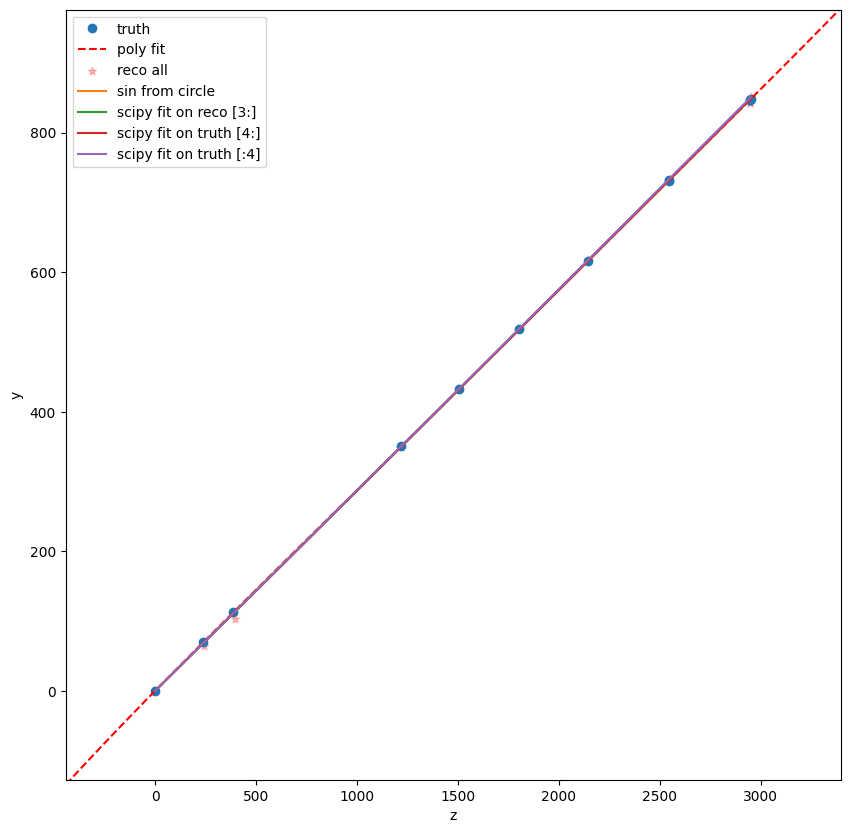

In [75]:
popt_zy, pcov = curve_fit(sin_test, Z[:4], Y[:4], p0=(1/4000) )
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]

ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on truth [:4]')

ax_zy.legend()
fig_zy

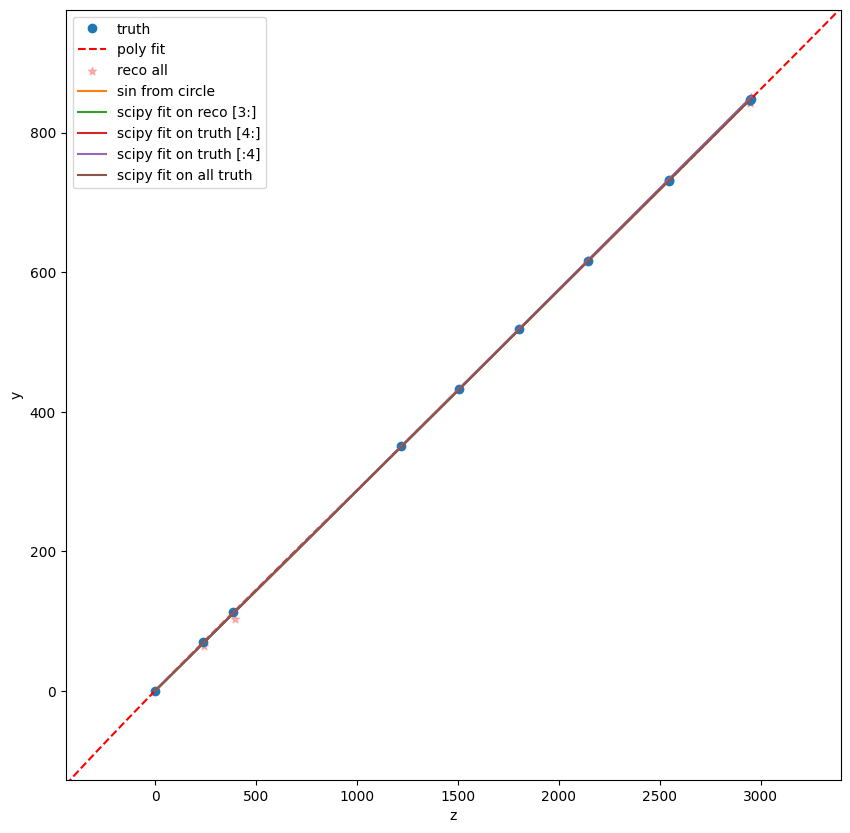

In [76]:
# popt_zy, pcov = curve_fit(sin_test, Z, Y, p0=(1/4000,np.arcsin(- center_y / r)) )
popt_zy, pcov = curve_fit(sin_test, Z, Y, p0=(1/4000) )
# f, phi_0 = popt_zy
f = popt_zy
fitted_func_zy = lambda x_arr: [sin_test(x, *popt_zy) for x in x_arr]

ax_zy.plot(z_in, fitted_func_zy(z_in), label='scipy fit on all truth')

ax_zy.legend()
fig_zy

### Plot $z, x$

In [77]:
# combined = lambda: x, fcos_test()
# popt_zx, pcov = curve_fit(cos_test, Z, X, p0=(1/4000,np.arccos(- center_x / r)) )
popt_zx, pcov = curve_fit(cos_test, Z, X, p0=(1/4000) )

In [78]:
popt_zy, popt_zx # f, phi

(array([-1.16317325e-05]), array([-1.16919161e-05]))

In [79]:
fitted_func_zx = lambda x_arr: [cos_test(x, *popt_zx) for x in x_arr]

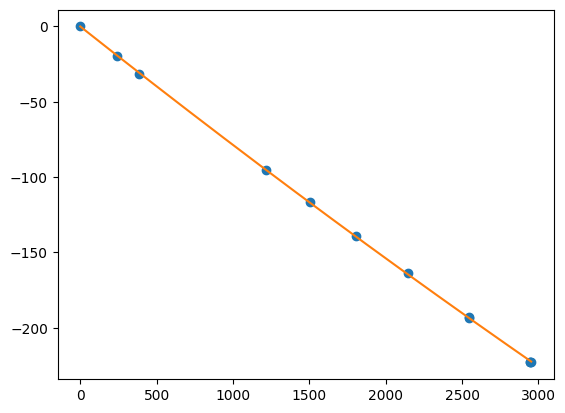

In [80]:
# plt.plot(z_in, fitted_func_zx(z_in), label='scipy fit on all truth')


plt.plot(Z,X, 'o',label='truth')
# plt.plot(z_in, r*np.cos(phi_0 + z_in *f) + center_x
plt.plot(z_in, fitted_func_zx(z_in), label='scipy fit on all truth')

# Global validator

## Define functions

In [81]:
def are_collinear(point1, point2, point3, threshold =  1.0e-6):
    assert len(point1) == len(point2) == len(point3) == 3, "Points must be in 3D space."

    # Create vectors from point1 to point2 and from point1 to point3
    vector1 = np.array(point2) - np.array(point1)
    vector2 = np.array(point3) - np.array(point1)

    # Compute the cross product of the vectors
    cross_product = np.cross(vector1, vector2)

    # Check if the cross product is the zero vector
    return np.linalg.norm(cross_product) < threshold

def line_equation(p1: tuple[float, float, float], p2: tuple[float, float, float]):
    """Get line equation from two points in 3D space.
    Returns 
    """
    x1, y1, z1 = p1
    x2, y2, z2 = p2

    # Define line equation intercept + z * slope
    x = lambda z: x1 + (z - z1) * ((x2 - x1) / (z2 - z1))
    y = lambda z: y1 + (z - z1) * ((y2 - y1) / (z2 - z1))

    return x, y


def validator_line(x: float, y: float, z: float, p1: tuple[float, float, float],  p2: tuple[float, float, float], abs_tolerance_line: float = 0, rel_tolerance: float = 0, info: bool = False, **kwargs) -> bool | dict:
    """Validate a point against a line in 3D space passing through `p1` and `p2`."""
    # Get equation in 3D space passing through p1 and p2
    x_eq, y_eq = line_equation(p1, p2)

    distance = lambda z: np.sqrt((x_eq(z) - x) ** 2 + (y_eq(z) - y) ** 2 + (z - z) ** 2)
    result = minimize(distance, x0=z)
    min_dist = result.fun
    z_min = result.x[0]

    validated = min_dist <= abs_tolerance_line # ignores rel tolerance

    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "diff": min_dist,
            "z_min": z_min,
            "eq_yz": y_eq,
            "eq_xz": x_eq,
        }
        

def validator_trig(x: float, y: float, z: float, center: tuple[float, float], r: float, f: float, phi_0: float, z_0: float, abs_tolerance = 0, rel_tolerance = 0, info: bool = False) -> bool | dict:
    """Validate against a sin and cos function."""
    # Define test functions
    center_x, center_y = center
    sin_test = lambda x: trig(x, r, 0, f, phi_0, z_0, center_y) # yz plane
    cos_test = lambda x: trig(x, 0, r, f, phi_0, z_0, center_x) # xz plane
    
    # Test sin in yz plane
    distance_sin = lambda z_t: np.sqrt((z_t - z) ** 2 + (sin_test(z_t) - y) ** 2)
    # Test cos in xz plane
    distance_cos = lambda z_t: np.sqrt((z_t - z) ** 2 + (cos_test(z_t) - x) ** 2)

    # Minimize functions to get distance
    result_yz = minimize(distance_sin, x0=z)
    result_xz = minimize(distance_cos, x0=z)

    # Get distance
    dist_yz = result_yz.fun
    dist_xz = result_xz.fun

    # Get z value of minimum
    z_min_yz = result_yz.x[0]
    z_min_xz = result_xz.x[0]
    z_min = (z_min_yz + z_min_xz) / 2

    # Get distance from z_min
    dist_z = abs(z - z_min)
    dist_x = abs(x - cos_test(z_min))
    dist_y = abs(y - sin_test(z_min))
    dist_xyz = np.sqrt(dist_x ** 2 + dist_y ** 2 + dist_z ** 2)
    

    validated_yz = dist_yz <= abs_tolerance or dist_yz <= rel_tolerance * r ** 2
    validated_xz = dist_xz <= abs_tolerance or dist_xz <= rel_tolerance * r ** 2
    validated_xyz = dist_xyz <= abs_tolerance or dist_xyz <= rel_tolerance * r ** 2
    validated = validated_yz and validated_xz and validated_xyz
    
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "validated_yz": validated_yz,
            "validated_xz": validated_xz,
            "validated_xyz": validated_xyz,
            "diff_yz": dist_yz,
            "diff_xz": dist_xz,
            "diff_z": dist_z,
            "diff_x": dist_x,
            "diff_y": dist_y,
            "diff_xyz": dist_xyz,
            "eq_yz": sin_test,
            "eq_xz": cos_test,
        }
    

def validator_helix(x: float, y: float, z: float, center: tuple[float, float], r: float, f: float, phi_0: float, z_0: float, abs_tolerance_r = 0, abs_tolerance_trig=0, rel_tolerance = 0, info: bool = False, verbose=True, **kwargs) -> bool | dict[str, bool | float | dict]:
    """Validate a point against a helix."""
    print("tolerances", abs_tolerance_r, abs_tolerance_trig, rel_tolerance)

    # Validate circle
    validation_circle: dict = validator_circle(x, y, center, r, abs_tolerance_r, rel_tolerance, info=True) # type: ignore
    if kwargs.get('verbose') == True:
        print("Circle validation:", validation_circle)
    # Fast return, skip further checking if circle is not validated already
    if not info and not validation_circle["validated"]:
        return False
    
    # Validate trig
    validation_trig: dict = validator_trig(x, y, z, center, r, f, phi_0, z_0, abs_tolerance_trig, rel_tolerance, info=True) # type: ignore
    if kwargs.get('verbose') == True:
        print("Trig validation:", validation_trig)

    validated = validation_circle["validated"] and validation_trig["validated"]

    diff = validation_trig["diff_xyz"]
    
    if not info:
        return validated
    else:
        return {
            "validated": validated,
            "validation_circle": validation_circle,
            "validation_trig": validation_trig,
            "diff": diff,
        }

def closer_to_sine_or_cosine_symmetry(phi):
    distance_to_sine_symmetry = min(abs((phi - math.pi/2) % math.pi), abs(math.pi - ((phi - math.pi/2) % math.pi)))
    distance_to_cosine_symmetry = min(abs(phi % math.pi), abs(math.pi - (phi % math.pi)))

    if distance_to_sine_symmetry < distance_to_cosine_symmetry:
        return "sine"
    elif distance_to_cosine_symmetry < distance_to_sine_symmetry:
        return "cosine"
    else:
        return "equal"

def get_f_fit(X_arr, Y_arr, Z_arr, r, phi_0, z_0, center):
    center_x, center_y = center
    
    # Define test functions
    cos_test = lambda x, f: trig(x, 0, r, f, phi_0, z_0, center_x)
    sin_test = lambda x, f: trig(x, r, 0, f, phi_0, z_0, center_y)
    
    # Fit functions to data
    popt_zx, pcov = curve_fit(cos_test, Z_arr, X_arr, p0=0)
    popt_zy, pcov = curve_fit(sin_test, Z_arr, Y_arr, p0=0)

    # Get f
    f_zx  = popt_zx[0]
    f_zy  = popt_zy[0]
    f_zx_abs = abs(f_zx)
    f_zy_abs = abs(f_zy)
    f_abs = (f_zy_abs + f_zx_abs) / 2
    
    # If a function is symmetric around z_0, the sign of f is not well defined
    # The sign of f is best determined by the function that is least symmetric around z_0
    closest_symmetry = closer_to_sine_or_cosine_symmetry(phi_0)
    if closest_symmetry == "sine":
        # Cosine corresponds with zy, since sin is likely to be symmetric around z_0, choose sign of f_zx
        f_sign = np.sign(f_zx)
    elif closest_symmetry == "cosine":
        # Cosine corresponds with zx, since cos is likely to be symmetric around z_0, choose sign of f_zy
        f_sign = np.sign(f_zy)
    else:
        assert np.sign(f_zx) == np.sign(f_zy), "Signs of f_zx and f_zy should be equal."
        f_sign = np.sign(f_zx)

    f = f_sign * f_abs
    return f
    


def get_validator(*args: tuple[tuple[float,float,float],tuple[float,float,float],tuple[float,float,float]] | tuple[Iterable, Iterable, Iterable], thr_collinear =  1.0e-6, info: bool = False, **kwargs):
    """Get validation function for a track in x, y, z plane. 
    
    Input needs to be in the form of [(x1, x2, x3), (y1, y2, y3), (z1, z2, z3).
    
    Currently only supports 3 points as fit points.
    """
    X_arr, Y_arr, Z_arr = args
    p1 = (X_arr[0], Y_arr[0], Z_arr[0])
    p2 = (X_arr[1], Y_arr[1], Z_arr[1])
    p3 = (X_arr[2], Y_arr[2], Z_arr[2])


    if are_collinear(p1, p2, p3, threshold=thr_collinear):
        # Since collinear, only need to check two points

        print("Validator is 3D line")
        return lambda x, y, z: validator_line(x, y,z, p1, p2, info=info, **kwargs) # type: ignore
    # Circle
    else:
        print("Validator is helix")

        # Get circle
        center, r = define_circle(p1, p2, p3)
        # Get phi_0
        phi_0 = get_phi_0(center, r)

        z_0 = 0 # TODO: lenience
        
        # Get f
        f = get_f_fit(X_arr, Y_arr, Z_arr, r, phi_0, z_0, center)

        # f = get_f_all(X_arr, Y_arr, Z_arr, center, r, phi_0, z_0)
        
        validator = lambda x, y, z: validator_helix(x, y, z, center, r, f, phi_0, z_0, info=info, **kwargs)
        if not info:
            return validator
        else:
            infodict = {
                "center": center,
                "r": r,
                "f": f,
                "f_zy": f_zy,
                "f_zx": f_zx,
                "phi_0": phi_0,
                "z_0": z_0,
            }
            return lambda x, y, z: validator(x, y, z) | infodict # type: ignore

In [82]:
validator_xyz = get_validator(X_t_3, Y_t_3, Z_t_3, abs_tolerance_line=10, abs_tolerance_r=10, abs_tolerance_trig=10, info=True)

values = [validator_xyz(x, y, z) for x, y, z in zip(X, Y, Z)]

for v in values:
    print(v)

Validator is helix
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
{'validated': True, 'validation_circle': {'validated': True, 'diff': 0.16997707523478311}, 'validation_trig': {'validated': True, 'validated_yz': True, 'validated_xz': True, 'validated_xyz': True, 'diff_yz': 1.501298941623075, 'diff_xz': 0.605695342118513, 'diff_z': 0.2309435090590739, 'diff_x': 0.5893048979087325, 'diff_y': 1.495573467322174, 'diff_xyz': 1.6239935847268026, 'eq_yz': <function validator_trig.<locals>.<lambda> at 0x7f0058777910>, 'eq_xz': <function validator_trig.<locals>.<lambda> at 0x7f0058777f40>}, 'diff': 1.6239935847268026, 'center': (24613.020364179407, 6870.6646848956625), 'r': 25553.997821471745, 'f': -1.1640079673376634e-05, 'f_zy': array([-1.16400864e-05]), 'f_zx': array([-1.16400729e-05]), 'phi_0': -2.869374588695428

## Test validator with truth data

In [83]:
# validator_xyz(0, 0, 0)['validated']
validator_helix(0, 0, 0, center, r, f, phi_0, z_0, info=True)

tolerances 0 0 0


{'validated': array([ True]),
 'validation_circle': {'validated': True, 'diff': 0.0},
 'validation_trig': {'validated': array([ True]),
  'validated_yz': True,
  'validated_xz': True,
  'validated_xyz': array([ True]),
  'diff_yz': 0.0,
  'diff_xz': 0.0,
  'diff_z': 0.0,
  'diff_x': array([0.]),
  'diff_y': array([0.]),
  'diff_xyz': array([0.]),
  'eq_yz': <function __main__.validator_trig.<locals>.<lambda>(x)>,
  'eq_xz': <function __main__.validator_trig.<locals>.<lambda>(x)>},
 'diff': array([0.])}

In [84]:
allowed = np.array([validator_xyz(x, y, z)['validated'] for x, y, z in zip(X_t,Y_t,Z_t)])
# allowed = [validator_xyz(x, y, z)['validated'] for x, y, z in zip(X_t,Y_t,Z_t)]
# allowed = np.array([validator_xyz(x, y, z) for x, y, z in zip(X_t,Y_t,Z_t)])
print(allowed)

tolerances 10 10 0
tolerances 10 10 0


tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
tolerances 10 10 0
[ True  True  True  True  True  True  True  True  True False False  True]


## Plot validations

In [85]:
r_0 = validator_xyz(0, 0, 0)
center = r_0['center']
r = r_0['r']
r_0
eq_yz = r_0['validation_trig']['eq_yz']
eq_xz = r_0['validation_trig']['eq_xz']
r_0

tolerances 10 10 0


{'validated': True,
 'validation_circle': {'validated': True, 'diff': 0.0},
 'validation_trig': {'validated': True,
  'validated_yz': True,
  'validated_xz': True,
  'validated_xyz': True,
  'diff_yz': 0.0,
  'diff_xz': 0.0,
  'diff_z': 0.0,
  'diff_x': 0.0,
  'diff_y': 0.0,
  'diff_xyz': 0.0,
  'eq_yz': <function __main__.validator_trig.<locals>.<lambda>(x)>,
  'eq_xz': <function __main__.validator_trig.<locals>.<lambda>(x)>},
 'diff': 0.0,
 'center': (24613.020364179407, 6870.6646848956625),
 'r': 25553.997821471745,
 'f': -1.1640079673376634e-05,
 'f_zy': array([-1.16400864e-05]),
 'f_zx': array([-1.16400729e-05]),
 'phi_0': -2.869374588695428,
 'z_0': 0}

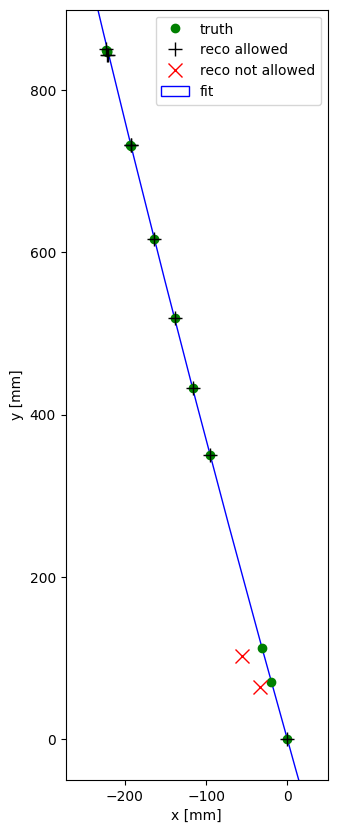

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X, Y, 'o', color='g', label='truth')
# ax.plot(X_t, Y_t, 'x', color='r', label='test')
ax.plot(X_t[allowed], Y_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.plot(X_t[~allowed], Y_t[~allowed], color='red', marker='x', markersize=10, label='reco not allowed', linestyle='None')

circle = plt.Circle(center, r, fill=False, color='b', label='fit')
ax.add_patch(circle)
ax.set_xlim(X.min()-50, X.max()+50)
ax.set_ylim(Y.min()-50, Y.max() + 50)
ax.set_aspect('equal', 'box')

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

ax.legend()

In [87]:
allowed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True])

[0.0, 0.8467347181440346, 1.6934775665886264, 2.5402285443078654, 3.3869876503231353, 4.233754883610345, 5.080530243177236, 5.9273137280333685, 6.774105337152832, 7.620905069547916, 8.467712924226362, 9.314528900163168, 10.16135299637699, 11.008185211846467, 11.855025545577519, 12.701873996579707, 13.548730563830759, 14.395595246348421, 15.242468043109511, 16.08934895312086, 16.93623797539385, 17.78313510890257, 18.630040352667493, 19.476953705663618, 20.323875166900507, 21.17080473538681, 22.017742410097526, 22.864688190040397, 23.711642074226802, 24.55860406162992, 25.40557415126932, 26.252552342122726, 27.09953863319788, 27.946533023502525, 28.793535512013477, 29.640546097750303, 30.48756477968618, 31.334591556832493, 32.18162642819698, 33.02866939275373, 33.87572044952503, 34.72277959748499, 35.56984683564042, 36.41692216300362, 37.26400557854686, 38.111097081279695, 38.95819667021169, 39.80530434431694, 40.652420102615, 41.49954394408087, 42.346675867725025, 43.193815872554296, 44

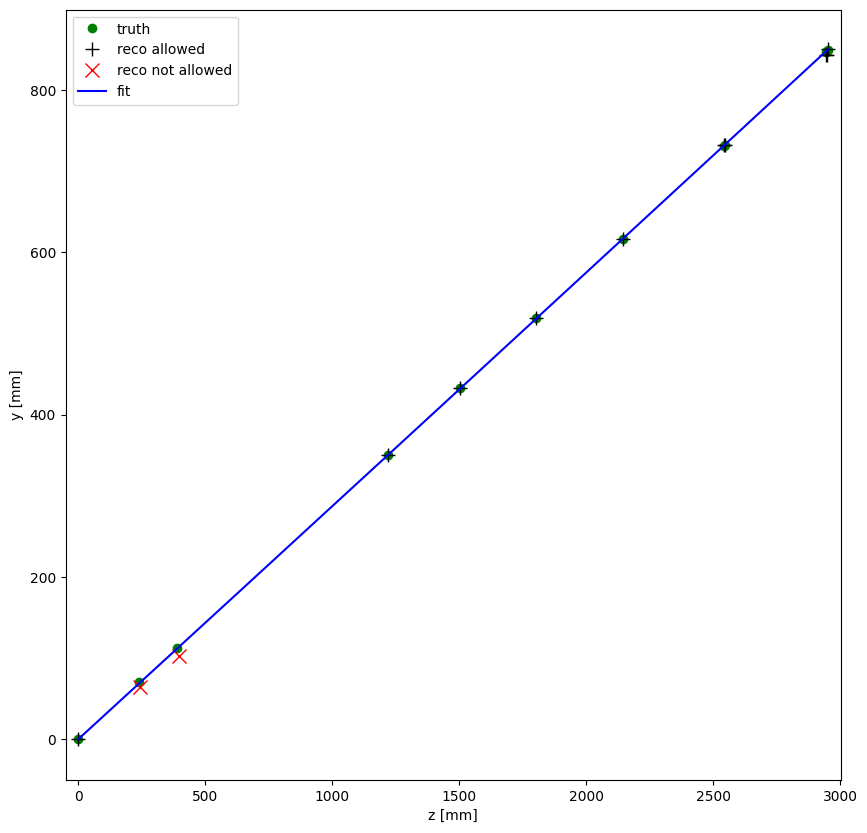

In [88]:
z_in = np.linspace(Z.min(), Z.max(), 1000)
y_out = [eq_yz(z) for z in z_in]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Z, Y, 'o', color='g', label='truth')
# ax.plot(Z_t, Y_t, 'x', color='r', label='test'))
ax.plot(Z_t[allowed], Y_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.plot(Z_t[~allowed], Y_t[~allowed], color='red', marker='x', markersize=10, label='reco not allowed', linestyle='None')
ax.plot(z_in, y_out, '-', color='b', label='fit')
ax.set_xlim(Z.min()-50, Z.max()+50)
ax.set_ylim(Y.min()-50, Y.max() + 50)

ax.set_xlabel('z [mm]')
ax.set_ylabel('y [mm]')
# ax.set_aspect('equal', 'box')

ax.legend()
print(y_out)

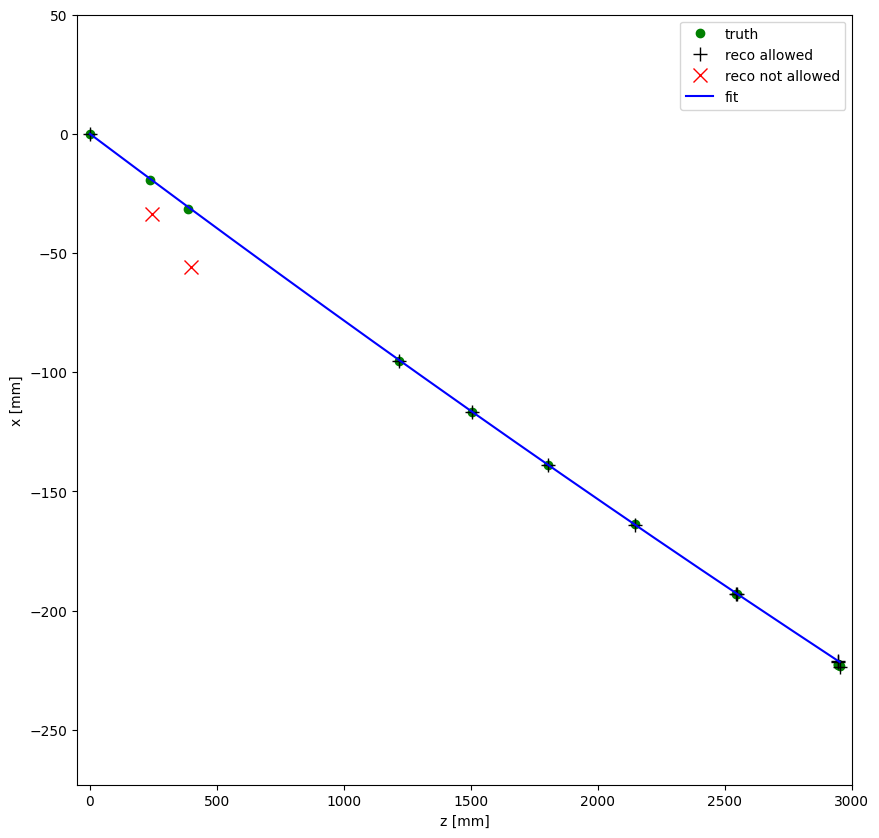

In [89]:
z_in = np.linspace(Z.min(), Z.max(), 1000)
x_out = [eq_xz(z) for z in z_in]

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Z, X, 'o', color='g', label='truth')
# ax.plot(Z_t, X_t, 'x', color='r', label='test')
ax.plot(Z_t[allowed], X_t[allowed], color='black', marker='+', markersize=10, label='reco allowed', linestyle='None')
ax.plot(Z_t[~allowed], X_t[~allowed], color='red', marker='x', markersize=10, label='reco not allowed', linestyle='None')
ax.plot(z_in, x_out, '-', color='b', label='fit')
ax.set_xlim(Z.min()-50, Z.max()+50)
ax.set_ylim(X.min()-50, X.max() + 50)

ax.set_xlabel('z [mm]')
ax.set_ylabel('x [mm]')
# ax.set_aspect('equal', 'box')

ax.legend()

# Insert limiting function in `get_path`

In [90]:
from numpy.typing import NDArray
from typing import Callable

def validator_from_path_idx(
    path_indices: list[int], 
    hits: pd.DataFrame, 
    abs_tolerance_line: float,
    abs_tolerance_r: float,
    abs_tolerance_trig: float,
    info: bool = True,
    **kwargs
) -> Callable[[float, float, float], dict]:
    x_2, y_2, z_2 = hits.iloc[path_indices][["x", "y", "z"]].values.T  # type: ignore
    # Add origin
    x_0, y_0, z_0 = 0, 0, 0
    x_3 = np.append(x_2, x_0)
    y_3 = np.append(y_2, y_0)
    z_3 = np.append(z_2, z_0)

    # Get validator
    validator = get_validator(
        x_3,  # type: ignore
        y_3,  # type: ignore
        z_3,  # type: ignore
        abs_tolerance_line=abs_tolerance_line,
        abs_tolerance_r=abs_tolerance_r,
        abs_tolerance_trig=abs_tolerance_trig,
        verbose=False,
        info = info
    )
    
    return validator


def path_add_one(
    path_indices: list[int],
    mask: NDArray,
    a: float | NDArray,
    validator: Callable[[float, float, float], dict] | None,
    thr: float,
    module_id: NDArray,
    skip_same_module: bool = True,
    preds: list[NDArray] | None = None,
    features: NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
    fit: bool = False,
    abs_tolerance_line: float = 10,
    abs_tolerance_r: float = 10,
    abs_tolerance_trig: float = 10, 
    **kwargs
):
    # Predict probability of each pair of hits with the last hit in the path
    hit_id_last = path_indices[-1] + 1

    if preds is not None:
        p = retrieve_predict(hit_id_last, preds)
    else:
        p = make_predict(model=model, features=features, hits=hits, hit_id=hit_id_last, thr=thr) # type: ignore

    # Generate mask of hits that have a probability above the threshold
    mask = (p > thr) * mask
    # Mask last added hit
    mask[path_indices[-1]] = 0

    if skip_same_module:
        path_ids = np.array(path_indices) + 1
        mask = mask_same_module(mask, path_ids, p, thr, module_id)

    # `a` is the culuminative probability between each hit in the path
    # At each step we look at the best candidate for the whole (previously geberate) track
    a = (p + a) * mask

    # When two points are added, we can build a helix and use it to validate the next point
    if fit and validator is None and len(path_indices) == 2:
        validator = validator_from_path_idx(**locals()) # type: ignore

    # TODO
    # p_ = p + diffs(p) * weight

    # TODO
    # if validator(x,y)
    if validator:
        for i in range(100):
            cand_idx = a.argmax()
            x_t, y_t, z_t = hits.iloc[cand_idx][["x", "y", "z"]].values  # type: ignore
            validation = validator(x_t, y_t, z_t)
            print(validation)
            validated = validation["validated"]
            if not validated:
                a[cand_idx] = 0
                # mask[cand_idx] = 0
                continue
            else:
                break

    # Add index of hit with highest probability to path, proceed with this hit as the seed for the next iteration
    if a.max() > thr * len(path_indices):
        path_indices.append(a.argmax())  # type: ignore
        do_break = False
    # Breaking condition: if best average probability is below threshold, end path
    else:
        do_break = True

    return path_indices, mask, a, validator, do_break


def get_path_smart(
    hit_id: int,
    thr: float,
    mask: NDArray,
    module_id: NDArray,
    skip_same_module: bool = True,
    preds: list[NDArray] | None = None,
    features: NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
    fit = False,
    abs_tolerance_line=10,
    abs_tolerance_r=10,
    abs_tolerance_trig=10, 
):
    """Predict set of hits that belong to the same track as hit_id.
    Returns list[hit_id].
    """
    # Verify correct input
    if preds is None and (features is None or hits is None or model is None):
        raise ValueError("Either preds or features and truth must be provided")
    if fit and hits is None:
        raise ValueError("hits must be provided if fit=True")

    # Convert to index
    hit_index = hit_id - 1
    path_indices = [hit_index]
    a = 0
    
    validator = None
    while True:
        # Keep adding hits until breaking condition is met
        path_indices, mask, a, validator, do_break = path_add_one(**locals())
        if do_break:
            break
    # Convert indices back to hit_ids by adding 1
    return np.array(path_indices) + 1



In [91]:
apply_fit = True

In [92]:
path_test_idx = get_path_smart(hit_id_test, thr=PATH_THR, mask = np.ones(len(event.hits)), module_id=module_id,features= event.features, hits=event.hits, model=used_model, fit=apply_fit, abs_tolerance_line=2, abs_tolerance_r=2, abs_tolerance_trig=2) -1

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 17ms/step
Validator is helix
tolerances 2 2 0
{'validated': True, 'validation_circle': {'validated': True, 'diff': 0.11326949730573688}, 'validation_trig': {'validated': True, 'validated_yz': True, 'validated_xz': True, 'validated_xyz': True, 'diff_yz': 0.30172897799671694, 'diff_xz': 0.19823536459016944, 'diff_z': 0.04914064466288437, 'diff_x': 0.19510843553143786, 'diff_y': 0.29983552476642217, 'diff_xyz': 0.36108648061837606, 'eq_yz': <function validator_trig.<locals>.<lambda> at 0x7f005854fac0>, 'eq_xz': <function validator_trig.<locals>.<lambda> at 0x7f005854f910>}, 'diff': 0.36108648061837606, 'center': (24613.020364179407, 6870.6646848956625), 'r': 25553.997821471745, 'f': -1.1640079673376634e-05, 'f_zy': array([-1.16400864e-05]), 'f_zx': array([-1.16400729e-05]), 'phi_0': -2.869374588695428, 'z_0': 0}
1/1 [==============================] - 0s 17ms/step
tolerances 2 2 0
{'validated': True, 'validation_circle': {'validated': True, 'diff':

In [93]:
center, r

((24613.020364179407, 6870.6646848956625), 25553.997821471745)

In [94]:
path_test_data = event.hits.iloc[path_test_idx]
X_ts, Y_ts, Z_ts = path_test_data[['x', 'y', 'z']].values.T
X_ts = np.append(X_ts, x_0)
Y_ts = np.append(Y_ts, y_0)
Z_ts = np.append(Z_ts, z_0)
path_test_data

,hit_id,x,y,z,volume_id,layer_id,module_id
77462,77463,-138.863998,518.419006,1804.500000,14,6,136
78450,78451,-163.903000,616.796021,2145.500000,14,8,135
76418,76419,-116.740997,432.381012,1504.500000,14,4,136
93242,93243,-193.151001,731.958984,2547.500000,18,10,79
93238,93239,-193.056000,731.593994,2544.500000,18,10,77
75302,75303,-95.390099,350.447998,1218.500000,14,2,134
19535,19536,-8.631290,30.812300,106.299004,8,2,141
31040,31041,-31.386101,112.500000,387.631989,8,6,666
25607,25608,-19.553101,69.797897,238.070007,8,4,346


2023-08-29 00:04:18 DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', va

2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/fonts/STIXGeneral.otf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/fonts/SourceCodePro-BlackIt.ttf', name='Source Code Pro', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-08-29 00:04:18 DEBUG    findfont: score(FontEntry(fname='/project/atlas/users/lschoonh/miniconda/envs/myrootenv/fonts/times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-08-2

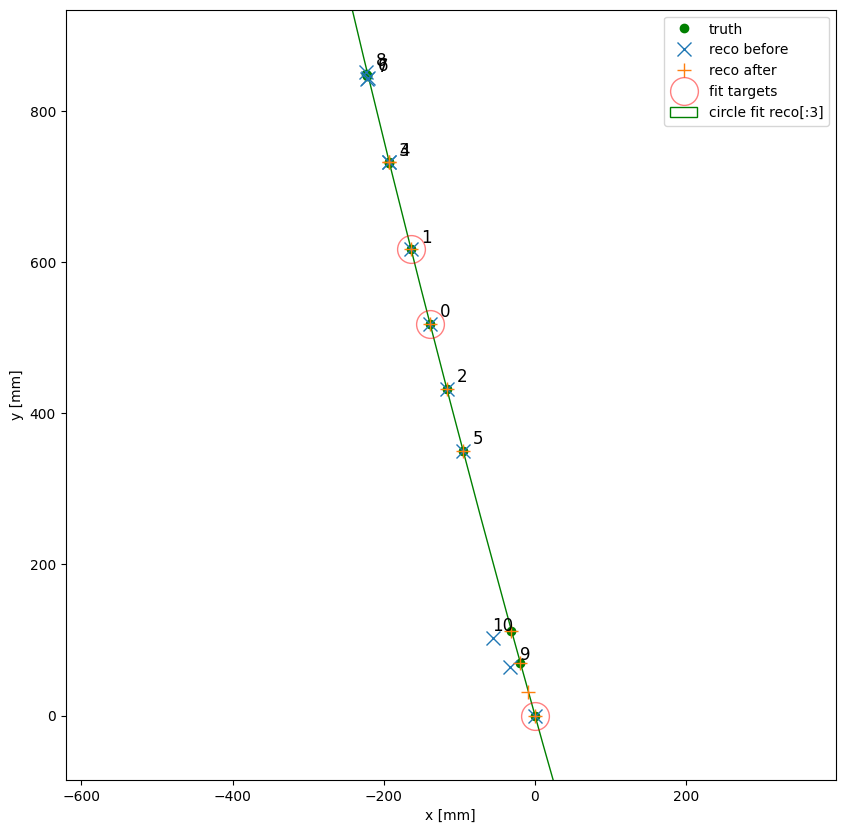

In [95]:
# fig, ax = plot_fit(X_t_3,Y_t_3,Z_t_3, *do_fit(X_t_3,Y_t_3,Z_t_3, deg=2, crop=5), 'y', label='reco[:3]', crop=5)
# ax.plot(Z,Y,'g--', label='truth', marker='x', markersize=10, alpha=0.5)
# ax.scatter(Z_t, Y_t, color='red', marker='x',label='reco', alpha= 0.2)
# ax.legend()
# ax

plt.subplots(figsize=(10,10))
plt.plot(X,Y, 'go', label='truth')
plt.plot(X_t, Y_t, 'x', label='reco before' , markersize=10)
plt.plot(X_ts, Y_ts, '+', label='reco after' , markersize=10)
plt.plot([*X_ts[:2],0],[*Y_ts[:2], 0],'o', color='r', fillstyle='none', alpha=0.5, label = 'fit targets', markersize=20)
circle = plt.Circle(center, r, fill=False, color='g', label = 'circle fit reco[:3]')
plt.gca().add_patch(circle)

for i, (x, y, z) in enumerate(zip(X_t[:-1], Y_t[:-1], Z_t[:-1])):
    plt.annotate(text=str(i), xy=(x, y), xytext =(15,5), ha='right', textcoords='offset points', fontsize=12)

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

xlim_0, ylim_0 = get_crop(X, Y, crop=crop, square=True)
xlim_1, ylim_1 = get_crop(X_ts, Y_ts, crop=crop, square=True)
xlim = (min(xlim_0[0], xlim_1[0]), max(xlim_0[1], xlim_1[1]))
ylim = (min(ylim_0[0], ylim_1[0]), max(ylim_0[1], ylim_1[1]))
plt.xlim(xlim)
plt.ylim(ylim)

# plt.gca().figure.set_size_inches(10,10)
plt.gca().set_aspect('equal', 'box')
plt.legend()

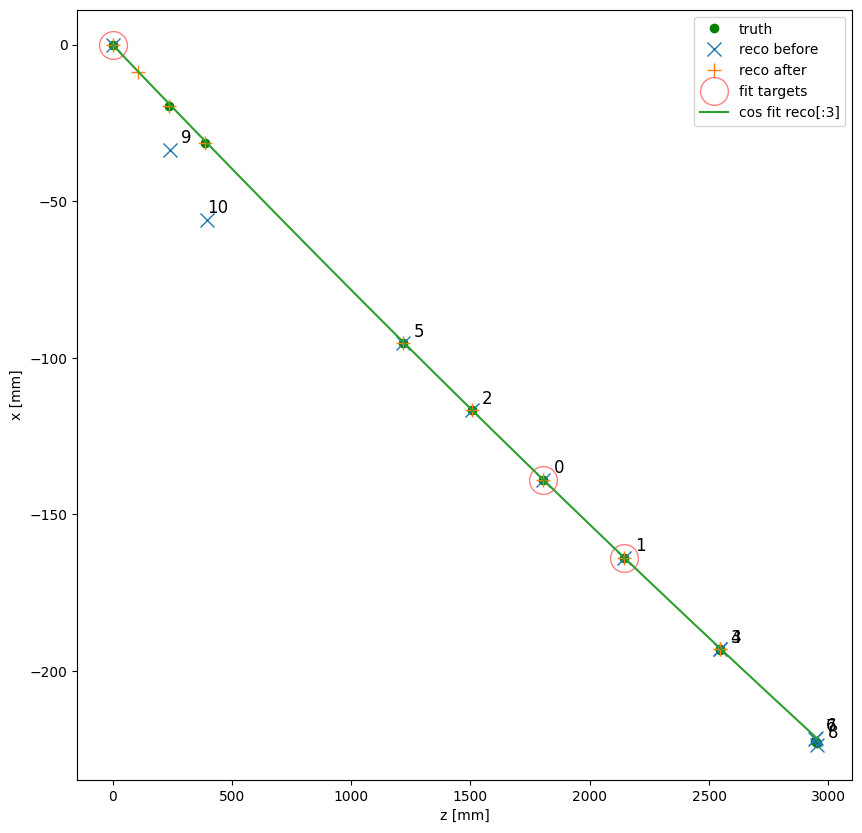

In [96]:
plt.subplots(figsize=(10,10))

plt.plot(Z,X, 'go', label = 'truth')
plt.plot(Z_t, X_t, 'x', label = 'reco before', markersize=10)
plt.plot(Z_ts, X_ts, '+', label = 'reco after', markersize=10)
plt.plot([*Z_ts[:2], 0],[*X_ts[:2],0],'o', color='r', fillstyle='none', alpha=0.5, label = 'fit targets', markersize=20)
plt.plot(z_in, [ cos_test(x, f_zx) for x in z_in], label='cos fit reco[:3]')

for i, (x, y, z) in enumerate(zip(X_t[:-1], Y_t[:-1], Z_t[:-1])):
    plt.annotate(text=str(i), xy=(z, x), xytext =(15,5), ha='right', textcoords='offset points', fontsize=12)

plt.xlabel('z [mm]')
plt.ylabel('x [mm]')
# xlim, ylim = get_crop(Z_ts, X_ts, crop=crop, square=False)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.gca().figure.set_size_inches(10,10)
plt.legend()

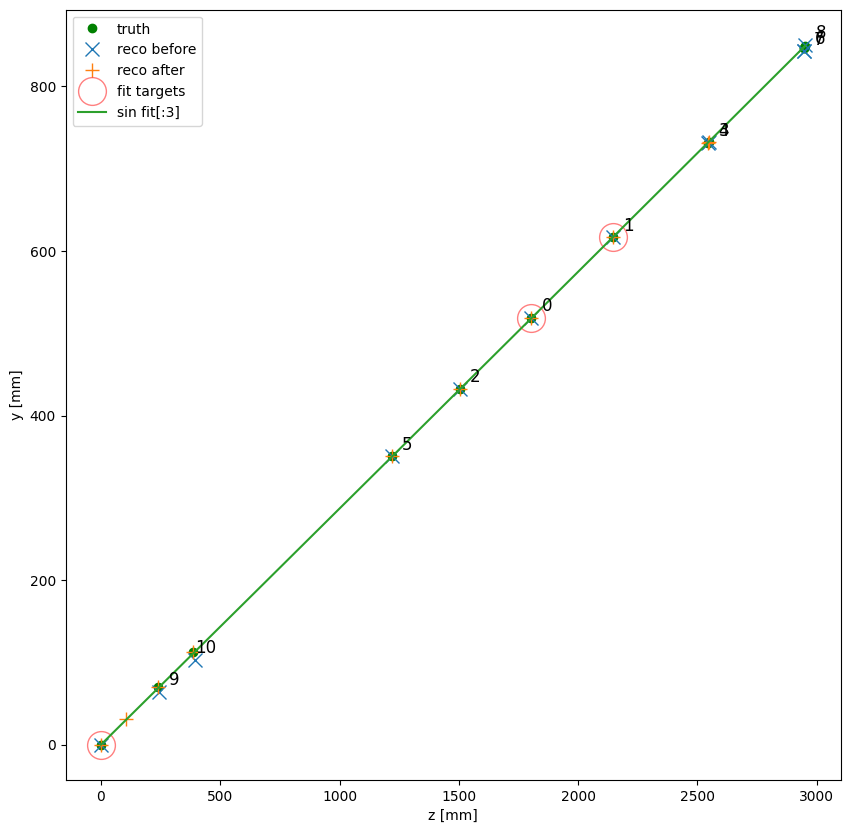

In [97]:
plt.subplots(figsize=(10,10))

plt.plot(Z,Y, 'go', label='truth')
plt.plot(Z_t, Y_t, 'x', label='reco before', markersize=10)
plt.plot(Z_ts, Y_ts, '+', label='reco after', markersize=10)
plt.plot([*Z_ts[:2], 0],[*Y_ts[:2], 0],'o', color='r', fillstyle='none', alpha=0.5, label = 'fit targets', markersize=20)
plt.plot(z_in, [ sin_test(x, f_zx) for x in z_in], label='sin fit[:3]')

for i, (x, y, z) in enumerate(zip(X_t[:-1], Y_t[:-1], Z_t[:-1])):
    plt.annotate(text=str(i), xy=(z, y), xytext =(15,5), ha='right', textcoords='offset points', fontsize=12)

plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
# xlim, ylim = get_crop(Z_ts, Y_ts, crop=crop, square=False)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.gca().figure.set_size_inches(10,10)
plt.legend()

# try (inv) attenuated sine freq; first perturbation?

In [98]:
X_att = np.linspace(0, 16000, 2000)

(0.0, 1.0)

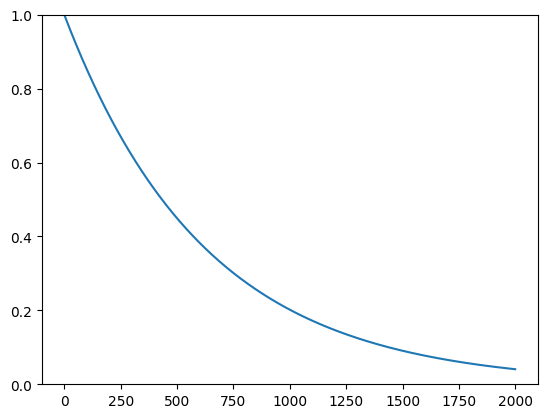

In [99]:
att = 2 / 10 ** 4
attfunc = lambda x: np.exp(-x* att)
plt.plot(np.exp(-X_att* att))
plt.ylim(0,1)

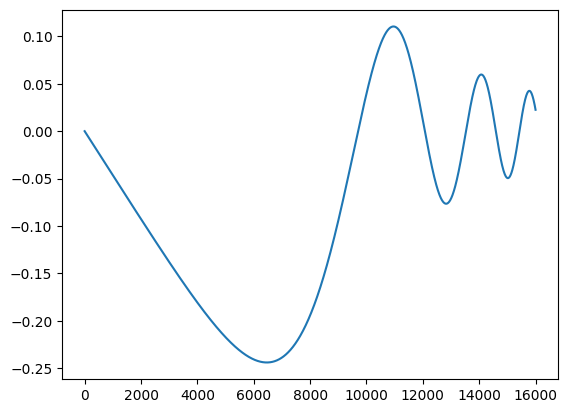

In [100]:
plt.plot(X_att, np.sin(X_att * f * 4 / attfunc(X_att))* attfunc(X_att), label='Signal')

# Plot adjacency

In [101]:
def get_history(
    hit_id: int,
    thr: float,
    mask: npt.NDArray,
    module_id: npt.NDArray,
    skip_same_module: bool = True,
    preds: list[npt.NDArray] | None = None,
    features: npt.NDArray | None = None,
    hits: pd.DataFrame | None = None,
    model: Model | None = None,
):
    """Predict set of hits that belong to the same track as hit_id.
    Returns list[hit_id].
    """
    # Verify correct input
    if preds is None:
        assert features is not None and hits is not None, "Either preds or features and truth must be provided"

    # Convert to index
    hit_index = hit_id - 1
    path_indices = [hit_index]
    a = 0
    history = []
    while True:
        # Predict probability of each pair of hits with the last hit in the path
        hit_id_last = path_indices[-1] + 1
        if preds is not None:
            p = retrieve_predict(hit_id_last, preds)
        else:
            if features is None or hits is None or model is None:
                raise ValueError("Either preds or (features & hits & model) must be provided")

            p = make_predict(model=model, features=features, hits=hits, hit_id=hit_id_last, thr=thr)

    
        # TODO
        # p_ = p + diffs(p) * weight

        # Generate mask of hits that have a probability above the threshold
        mask = (p > thr) * mask
        # Mask last added hit
        mask[path_indices[-1]] = 0

        if skip_same_module:
            path_ids = np.array(path_indices) + 1
            mask = mask_same_module(mask, path_ids, p, thr, module_id)
            
        # TODO
        # if validator(x,y)

        # `a` is the culuminative probability between each hit in the path
        # At each step we look at the best candidate for the whole (previously geberate) track
        a = (p + a) * mask

        # Breaking condition: if best average probability is below threshold, end path
        if a.max() < thr * len(path_indices):
            break
        # Add index of hit with highest probability to path, proceed with this hit as the seed for the next iteration
        path_indices.append(a.argmax())  # type: ignore
        history.append(a.copy())
    # Convert indices back to hit_ids by adding 1
    return history

In [102]:
history = get_history(hit_id_test, thr=PATH_THR, mask = np.ones(len(event.hits)), module_id=module_id,features= event.features, hits=event.hits, model=used_model)


5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 17ms/step


In [103]:
print(history[0].argmax())
print(path_test_idx)

num_top = 25
top = [np.argsort(a)[-num_top:] for a in history]

78450
[77462 78450 76418 93242 93238 75302 19535 31040 25607]


In [104]:
history_frames = [event.hits.iloc[top[i]] for i in range(len(top))]
for i in range(len(history_frames)):
    history_frames[i]['iteration'] = i
    history_frames[i]['probability'] = history[i][top[i]]

/tmp/ipykernel_31334/2641001525.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_frames[i]['iteration'] = i
/tmp/ipykernel_31334/2641001525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_frames[i]['probability'] = history[i][top[i]]
/tmp/ipykernel_31334/2641001525.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [105]:
history_frames = pd.concat(history_frames)

/tmp/ipykernel_31334/2237949154.py:38: RuntimeWarning: divide by zero encountered in log
  ax.scatter(frame[c_1], frame[c_2], s=5/-np.log(a_i), alpha=0.5, label=f'adjacency iteration {i+1}')
/tmp/ipykernel_31334/2237949154.py:31: RuntimeWarning: divide by zero encountered in log
  ax.scatter(frame[c_1], frame[c_2], s=3/-np.log(a_i), alpha=0.5/(j+1))


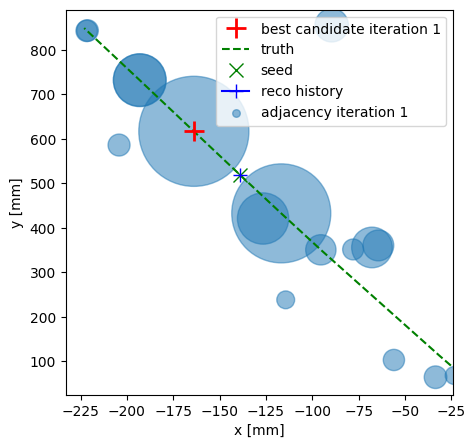

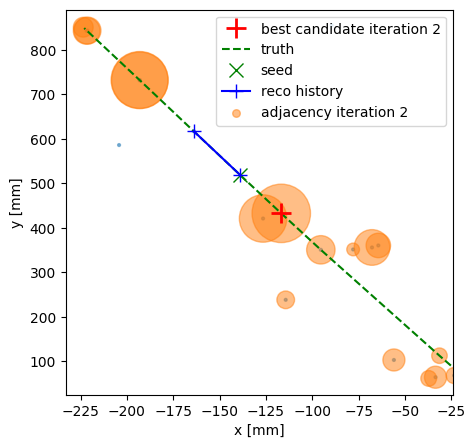

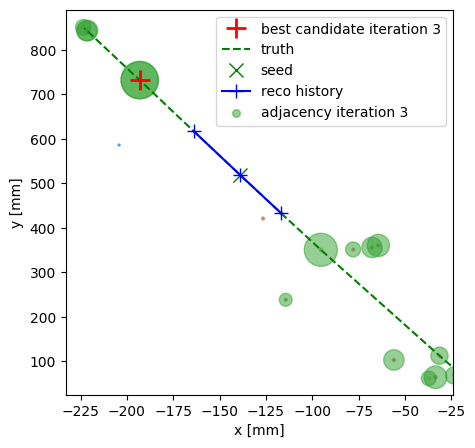

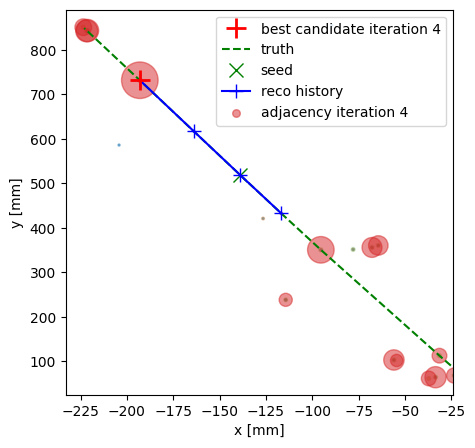

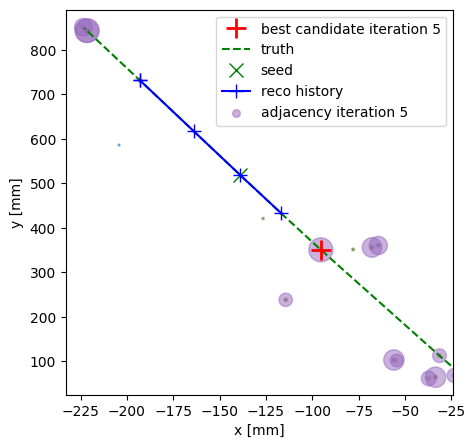

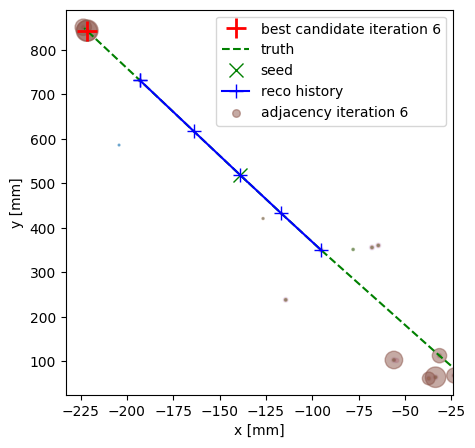

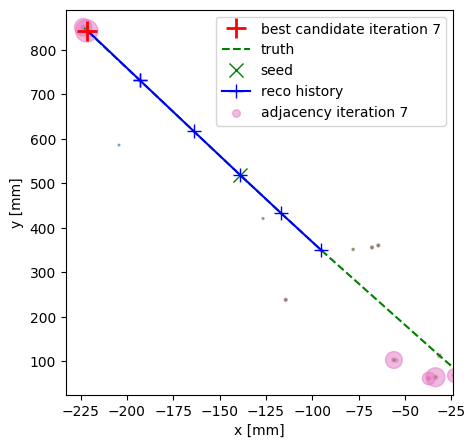

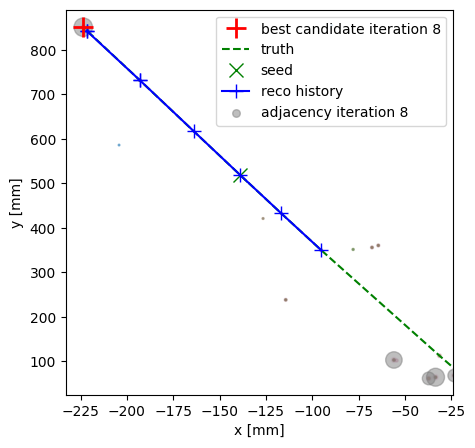

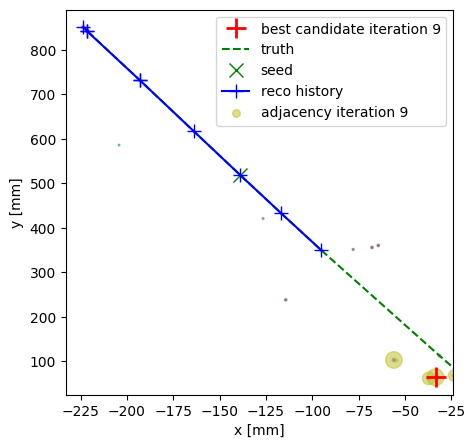

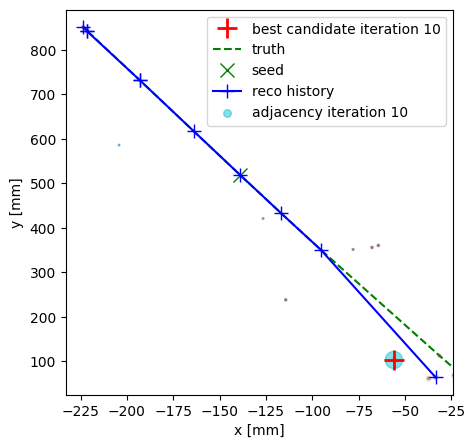

In [113]:
c_1, c_2 = 'x', 'y'
crop = get_crop(X_t[:10], Y_t[:10], crop=1.1, square=False)
seed_pos = event.hits.iloc[hit_id_test-1]

for i in range(0,len(history)):
    zorder=len(history)+1

    fig, ax = plt.subplots(figsize=(5,5))

    best_candidate_idx = history[i].argmax()
    cand_data = event.hits.iloc[best_candidate_idx]
    ax.plot(cand_data[c_1], cand_data[c_2], 'r+', label=f"best candidate iteration {i+1}", zorder=zorder, markersize=15, markeredgewidth=2)

    _Z_order = np.argsort(Z)
    _X = X[_Z_order]
    _Y = Y[_Z_order]
    ax.plot(_X,_Y, 'g--', label='truth', zorder=zorder-1,  markersize=10)
    ax.plot(seed_pos['x'], seed_pos['y'], 'gx', markersize=10, label='seed')

    _Z_t_order = np.argsort(Z_t[:i+1])
    _Y_t = Y_t[:i+1][_Z_t_order]
    _X_t = X_t[:i+1][_Z_t_order]
    ax.plot(_X_t, _Y_t, 'b+-', label='reco history', zorder=zorder-1,  markersize=10)
    for j in range(0, i):
        # Plot best candidate
        
        # Plot all candidates best
        candidates_idx = history_frames[history_frames['iteration'] <= j]['hit_id'].unique() - 1
        frame = event.hits.iloc[candidates_idx]
        a_i = history[j][candidates_idx] / (i+1)
        ax.scatter(frame[c_1], frame[c_2], s=3/-np.log(a_i), alpha=0.5/(j+1))

    candidates_idx = history_frames[history_frames['iteration'] <= i]['hit_id'].unique() - 1
    frame = event.hits.iloc[candidates_idx]
    a_i = history[i][candidates_idx] / (i+1)
    # a_i_min = min(a_i[np.where(a_i > 0.85)])
    
    ax.scatter(frame[c_1], frame[c_2], s=5/-np.log(a_i), alpha=0.5, label=f'adjacency iteration {i+1}')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_xlim(crop[0])
    ax.set_ylim(crop[1])
    # ax.legend(framealpha=0.2)
    lgnd = plt.legend(scatterpoints=1, fontsize=10)
    lgnd.legend_handles[-1]._sizes = [30]
    fig.savefig(f'history_xy_{i}.png')


In [107]:
i=10
history_frames[history_frames['iteration'] == i]['probability']/(i+1)

Series([], Name: probability, dtype: float64)

/tmp/ipykernel_31334/1986512449.py:39: RuntimeWarning: divide by zero encountered in log
  ax.scatter(frame['x'], frame['y'], frame['z'], s=5/-np.log(a_i), alpha=0.5, label=f'adjacency iteration {i+1}')
/tmp/ipykernel_31334/1986512449.py:33: RuntimeWarning: divide by zero encountered in log
  ax.scatter(frame['x'], frame['y'], frame['z'], s=50/-np.log(a_i), alpha=0.5/(j+1))


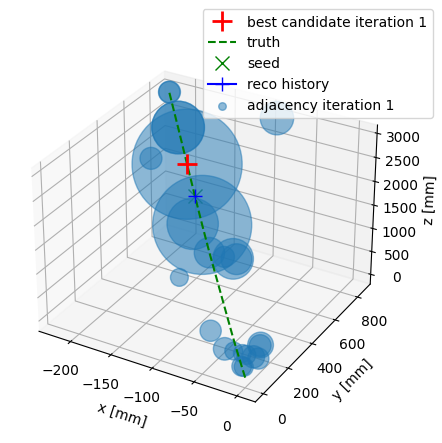

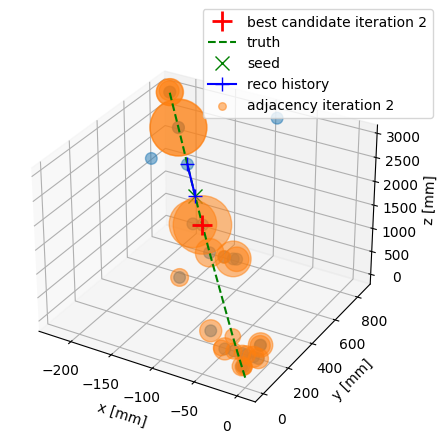

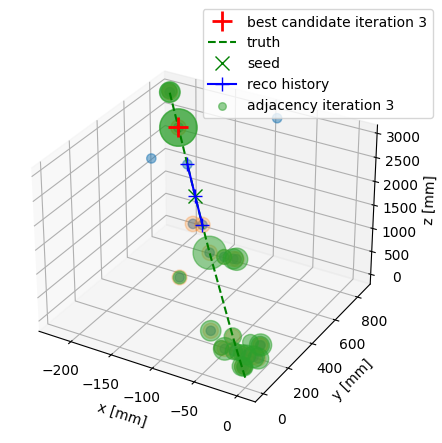

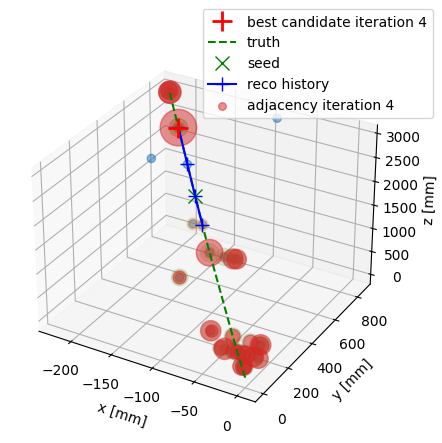

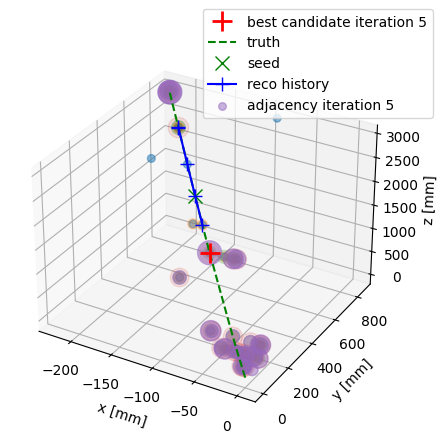

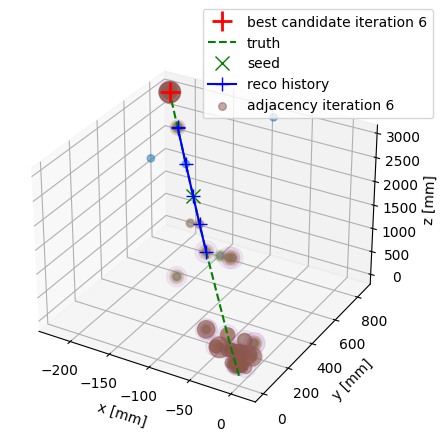

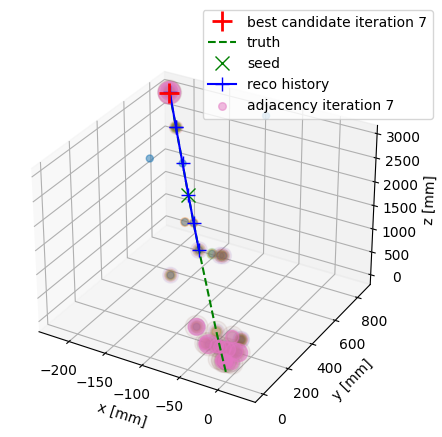

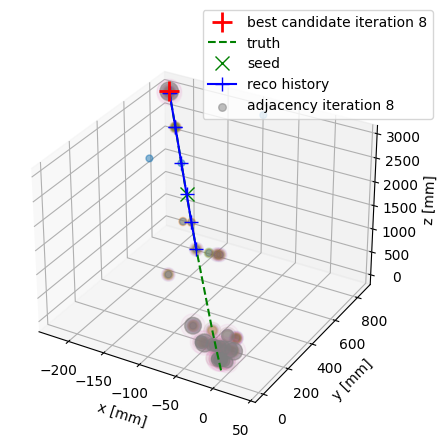

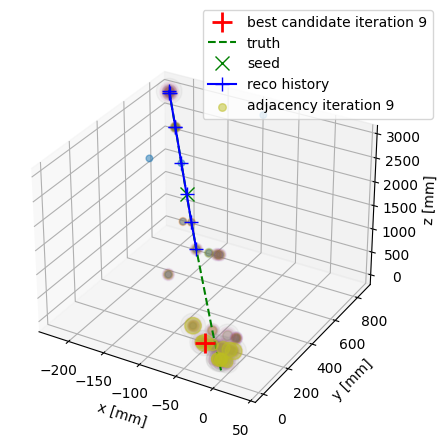

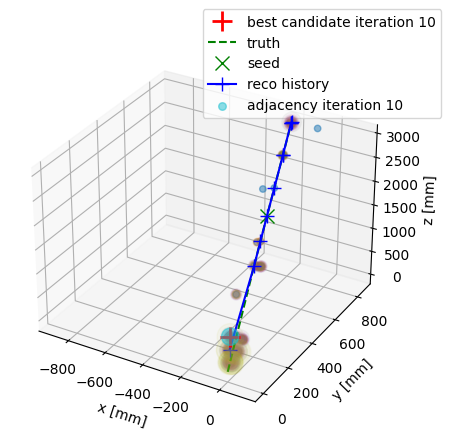

In [111]:
# crop = get_crop(X_t[:10], Y_t[:10], crop=1.1, square=False)
seed_pos = event.hits.iloc[hit_id_test-1]

for i in range(0,len(history)):
    zorder=len(history)+1

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    best_candidate_idx = history[i].argmax()
    cand_data = event.hits.iloc[best_candidate_idx]
    ax.plot(cand_data['x'], cand_data['y'],  cand_data['z'], 'r+', label=f"best candidate iteration {i+1}", zorder=zorder, markersize=15, markeredgewidth=2)

    _Z_order = np.argsort(Z)
    _X = X[_Z_order]
    _Y = Y[_Z_order]
    _Z = Z[_Z_order]
    ax.plot(_X,_Y,_Z, 'g--', label='truth', zorder=zorder-1,  markersize=10)
    ax.plot(seed_pos['x'], seed_pos['y'],seed_pos['z'], 'gx', markersize=10, label='seed')

    _Z_t_order = np.argsort(Z_t[:i+1])
    _X_t = X_t[:i+1][_Z_t_order]
    _Y_t = Y_t[:i+1][_Z_t_order]
    _Z_t = Z_t[:i+1][_Z_t_order]
    ax.plot(_X_t, _Y_t,_Z_t, 'b+-', label='reco history', zorder=zorder-1,  markersize=10)
    for j in range(0, i):
        # Plot best candidate
        
        # Plot all candidates best
        candidates_idx = history_frames[history_frames['iteration'] <= j]['hit_id'].unique() - 1
        frame = event.hits.iloc[candidates_idx]
        a_i = history[j][candidates_idx] / (i+1)
        ax.scatter(frame['x'], frame['y'], frame['z'], s=50/-np.log(a_i), alpha=0.5/(j+1))

    candidates_idx = history_frames[history_frames['iteration'] <= i]['hit_id'].unique() - 1
    frame = event.hits.iloc[candidates_idx]
    a_i = history[i][candidates_idx] / (i+1)
    
    ax.scatter(frame['x'], frame['y'], frame['z'], s=5/-np.log(a_i), alpha=0.5, label=f'adjacency iteration {i+1}')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]')
    # ax.set_xlim(crop[0])
    # ax.set_ylim(crop[1])
    # ax.legend(framealpha=0.7, loc='upper right')

    lgnd = plt.legend(loc=(0.5, 0.8), scatterpoints=1, fontsize=10)
    lgnd.legend_handles[-1]._sizes = [30]

    fig.gca().autoscale_view() #.tight_layout(h_pad=10)
    fig.savefig(f'history_xyz_{i}.png',bbox_inches='tight')


In [109]:
print('hey')

hey
